<a href="https://colab.research.google.com/github/deniseiras/BAM1D-Microphysics-Emulation/blob/main/BAM1D_Physics_Emulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BAM1D Physics Emulation

** Objetivo: ** Emular a Hugh Morrison Microphysics implementada em BAM1D


# Setup do dados

Carregamento dos dados

In [57]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import time
from sklearn import metrics

# %tensorflow_version 1.x

import tensorflow as tf
from tensorflow.python.data import Dataset

from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard

from datetime import datetime


# tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
# pd.options.display.float_format = '{:.1f}'.format
pd.options.display.float_format = '{:f}'.format

# working local
#
original_input_df = pd.read_csv("/home/denis/_COM_BACKUP/bam1d_physics_nn/hug_morr_inputs.csv", sep=",")
original_output_df = pd.read_csv("/home/denis/_COM_BACKUP/bam1d_physics_nn/hug_morr_outputs.csv", sep=",")

# loading manually at each run
#
# import io
# from google.colab import files
# uploaded = files.upload()
# original_input_df = pd.read_csv(io.StringIO(uploaded['hug_morr_inputs.csv'].decode('utf-8')), sep=",")
# original_output_df = pd.read_csv(io.StringIO(uploaded['hug_morr_outputs.csv'].decode('utf-8')), sep=",")

# loading from gdrive
#
# from google.colab import drive
# drive.mount('/content/drive')
# original_input_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/hug_morr_inputs.csv", sep=",")
# original_output_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/hug_morr_outputs.csv", sep=",")

# generate random lines
input_df = original_input_df.reindex(np.random.permutation(original_input_df.index))
output_df = original_output_df.reindex(np.random.permutation(original_output_df.index))


## Análise dos dados

### Análise estatística

- Resumo dos valores das variáveis de entrada e saída. Observe que os valores são truncados no Resumo
- Valores do primeiro, centésimo e último passo de tempo
- Níveis verticais do primeiro, centésimo e último passo de tempo

In [2]:
print("\nAll input summary:")
display.display(original_input_df.describe())
print("\nAll output summary:")
display.display(original_output_df.describe())


print("\nInput First timestep:")
display.display(original_input_df.head(28))
print("\nInput 100th timestep:")
display.display(original_input_df.loc[2800:2800+27])
print("\nInput Last timestep:")
display.display(original_input_df.tail(28))

print("\nOutput First timestep:")
display.display(original_output_df.head(28))
print("\nOutput 100th timestep:")
display.display(original_output_df.loc[2800:2800+27])
print("\nOutput Last timestep:")
display.display(original_output_df.tail(28))





All input summary:


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
count,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000
mean,14.500000,0.468551,0.000000,0.450519,240.921717,0.005842,0.000002,0.000001,0.000001,0.000030,0.000000,61165.494411,1043501.113801,4576.122062,0.001798,121900.322353,0.270647,28.647202,99000.000000,-0.031886
std,8.077762,0.363561,0.000000,0.361059,57.643654,0.006346,0.000016,0.000009,0.000006,0.000084,0.000000,278606.717186,3399577.554373,51098.109604,0.111052,980184.883190,1.144277,78.850032,0.000000,0.124607
min,1.000000,0.003669,0.000000,0.001523,76.927183,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,99000.000000,-1.040423
25%,7.750000,0.103880,0.000000,0.090635,199.164832,0.000047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,-0.032514
50%,14.500000,0.432240,0.000000,0.399916,260.250033,0.002262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.682792,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
75%,21.250000,0.834470,0.000000,0.811268,290.003008,0.012095,0.000000,0.000000,0.000000,0.000014,0.000000,0.000000,42529.564205,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.013516
max,28.000000,1.000000,0.000000,0.994964,310.312954,0.016855,0.000493,0.000329,0.000115,0.001189,0.000000,1744027.026220,22604778.815400,1740941.655300,21.011023,22999124.957800,6.000000,300.000000,99000.000000,0.240343



All output summary:


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
count,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000
mean,14.500000,240.923603,0.005841,0.000002,0.000001,0.000001,0.000030,0.000000,61176.006687,1043612.390624,4576.122062,0.001798,121900.322353,24.592588,28.428168,0.000000,0.000000
std,8.077762,57.638340,0.006348,0.000016,0.000009,0.000006,0.000084,0.000000,278629.584989,3399730.114833,51098.109604,0.111052,980184.883190,2.521517,14.624718,0.000002,0.000000
min,1.000000,76.927183,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,-0.000000,0.000000
25%,7.750000,199.163220,0.000036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
50%,14.500000,260.397331,0.002386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.691543,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
75%,21.250000,289.996409,0.012101,0.000000,0.000000,0.000000,0.000014,0.000000,0.000000,42531.493798,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
max,28.000000,310.312954,0.016964,0.000493,0.000329,0.000115,0.001189,0.000000,1744027.026220,22604778.815400,1740941.655300,21.011023,22999124.957800,27.606963,130.000000,0.000034,0.000000



Input First timestep:


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
0,1,1.000000,0.000000,0.994964,294.178437,0.016781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.695110,99000.000000,-0.000992
1,2,0.989934,0.000000,0.981964,294.000352,0.016364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.680441,99000.000000,-0.000187
2,3,0.974009,0.000000,0.964137,293.731351,0.015746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.001870
3,4,0.954290,0.000000,0.942167,293.174866,0.015051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.002775
4,5,0.930081,0.000000,0.915361,292.082711,0.014417,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,-0.001486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,24,0.042912,0.000000,0.035429,206.522315,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
24,25,0.028306,0.000000,0.022285,211.657434,0.000024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
25,26,0.016629,0.000000,0.011763,214.615690,0.000047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
26,27,0.007338,0.000000,0.005429,215.728153,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000



Input 100th timestep:


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
2800,1,1.000000,0.000000,0.994964,298.932034,0.016781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.783230,0.000000,0.000000,0.000000,5.942456,99000.000000,0.005799
2801,2,0.989934,0.000000,0.981964,297.683772,0.016364,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,13.199738,0.000000,0.000000,0.112661,14.177284,99000.000000,0.014684
2802,3,0.974009,0.000000,0.964137,295.962310,0.015746,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,23.761218,0.000000,0.000000,0.172518,9.592541,99000.000000,0.027000
2803,4,0.954290,0.000000,0.942167,294.081629,0.015051,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,64.334742,0.000000,0.000000,0.038173,5.716471,99000.000000,0.040628
2804,5,0.930081,0.000000,0.915361,292.862025,0.014417,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,276.518560,0.000000,0.000000,0.000000,0.920201,99000.000000,0.053077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2823,24,0.042912,0.000000,0.035429,206.515351,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
2824,25,0.028306,0.000000,0.022285,210.988762,0.000024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
2825,26,0.016629,0.000000,0.011763,203.719782,0.000047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
2826,27,0.007338,0.000000,0.005429,204.470623,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000



Input Last timestep:


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
265440,1,1.000000,0.000000,0.994964,304.673072,0.016781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.162274,99000.000000,-0.000728
265441,2,0.989934,0.000000,0.981964,303.636675,0.016364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.584893,99000.000000,0.001025
265442,3,0.974009,0.000000,0.964137,302.159501,0.015746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.422692,30.064203,99000.000000,0.002903
265443,4,0.954290,0.000000,0.942167,300.312571,0.015051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.032102,99000.000000,0.001065
265444,5,0.930081,0.000000,0.915361,298.005720,0.014417,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,-0.009210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265463,24,0.042912,0.000000,0.035429,186.593833,0.000003,0.000000,0.000000,0.000001,0.000049,0.000000,58817.619598,3345402.281040,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
265464,25,0.028306,0.000000,0.022285,166.784205,0.000024,0.000000,0.000000,0.000009,0.000091,0.000000,1334619.474820,9456286.900340,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
265465,26,0.016629,0.000000,0.011763,138.926510,0.000047,0.000000,0.000000,0.000000,0.000073,0.000000,0.000000,15370294.399400,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
265466,27,0.007338,0.000000,0.005429,114.091405,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,300.000000,99000.000000,0.000000



Output First timestep:


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
0,1,294.639907,0.016589,0.000181,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6677692.206590,20.267474,25.000000,0.000001,0.000000
1,2,294.138620,0.016306,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6762603.595160,13.678777,25.000000,0.000001,0.000000
2,3,293.731351,0.015746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
3,4,293.174866,0.015051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
4,5,292.082711,0.014417,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,24,206.522315,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
24,25,211.657434,0.000024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
25,26,214.615690,0.000047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
26,27,215.728153,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000



Output 100th timestep:


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
2800,1,298.930861,0.016782,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,13.137133,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
2801,2,297.682241,0.016364,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,18.629478,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
2802,3,295.960340,0.015747,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,34.481010,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
2803,4,294.078600,0.015052,0.000000,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,91.832575,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
2804,5,292.853591,0.014420,0.000000,0.000006,0.000000,0.000000,0.000000,0.000000,0.000000,381.136069,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2823,24,206.515351,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
2824,25,210.988762,0.000024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
2825,26,203.719782,0.000047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
2826,27,204.470623,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000



Output Last timestep:


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
265440,1,304.673072,0.016781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
265441,2,303.636675,0.016364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
265442,3,302.159501,0.015746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
265443,4,300.312571,0.015051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
265444,5,298.005720,0.014417,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265463,24,186.572133,0.000010,0.000000,0.000000,0.000001,0.000049,0.000000,58843.539750,3344665.313110,0.000000,0.000000,0.000000,25.000000,36.184921,0.000000,0.000000
265464,25,166.808175,0.000016,0.000000,0.000000,0.000009,0.000091,0.000000,1344231.263890,9457125.711490,0.000000,0.000000,0.000000,25.000000,24.337390,0.000000,0.000000
265465,26,138.980615,0.000030,0.000000,0.000000,0.000000,0.000073,0.000000,0.000000,15350885.696800,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
265466,27,114.091405,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000


### Histogramas das variáveis de entrada

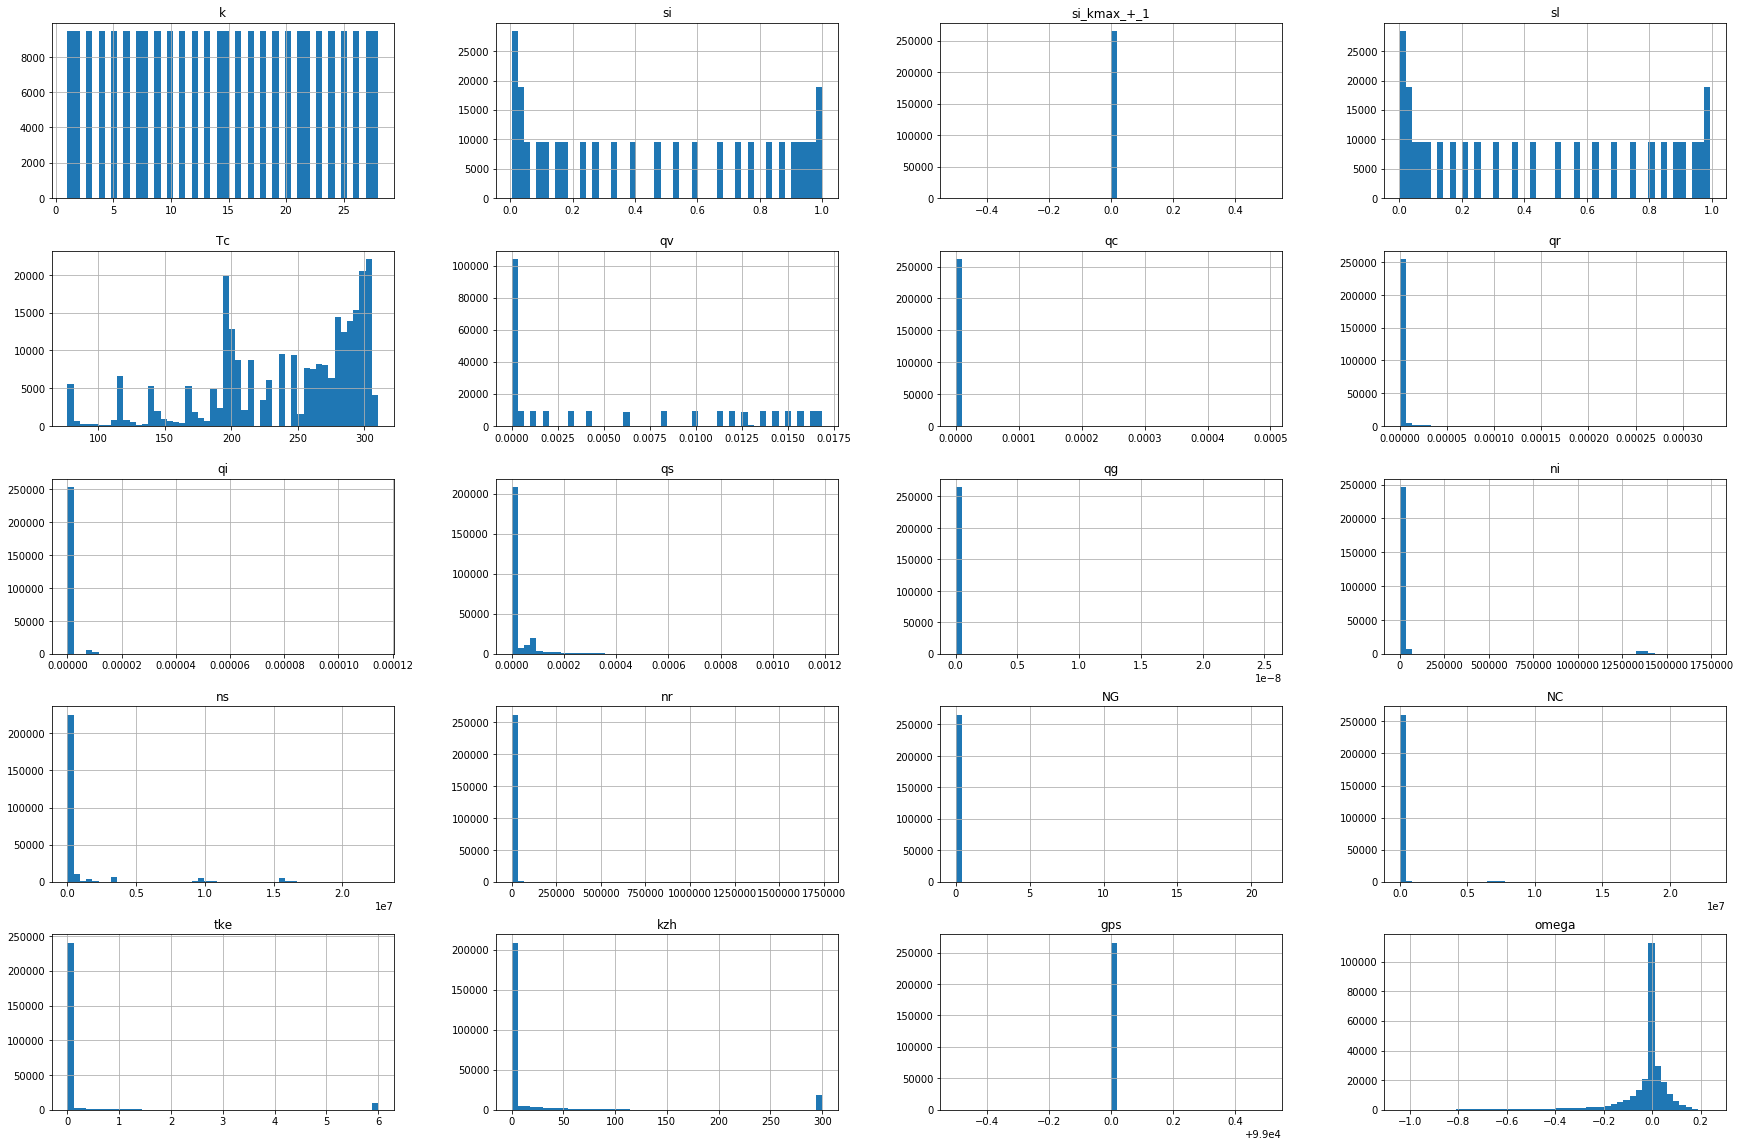

In [3]:
# Input Histograms

_ = original_input_df.hist(bins=50, figsize=(30, 20), xlabelsize=10)

### Histogramas das variáveis de saída

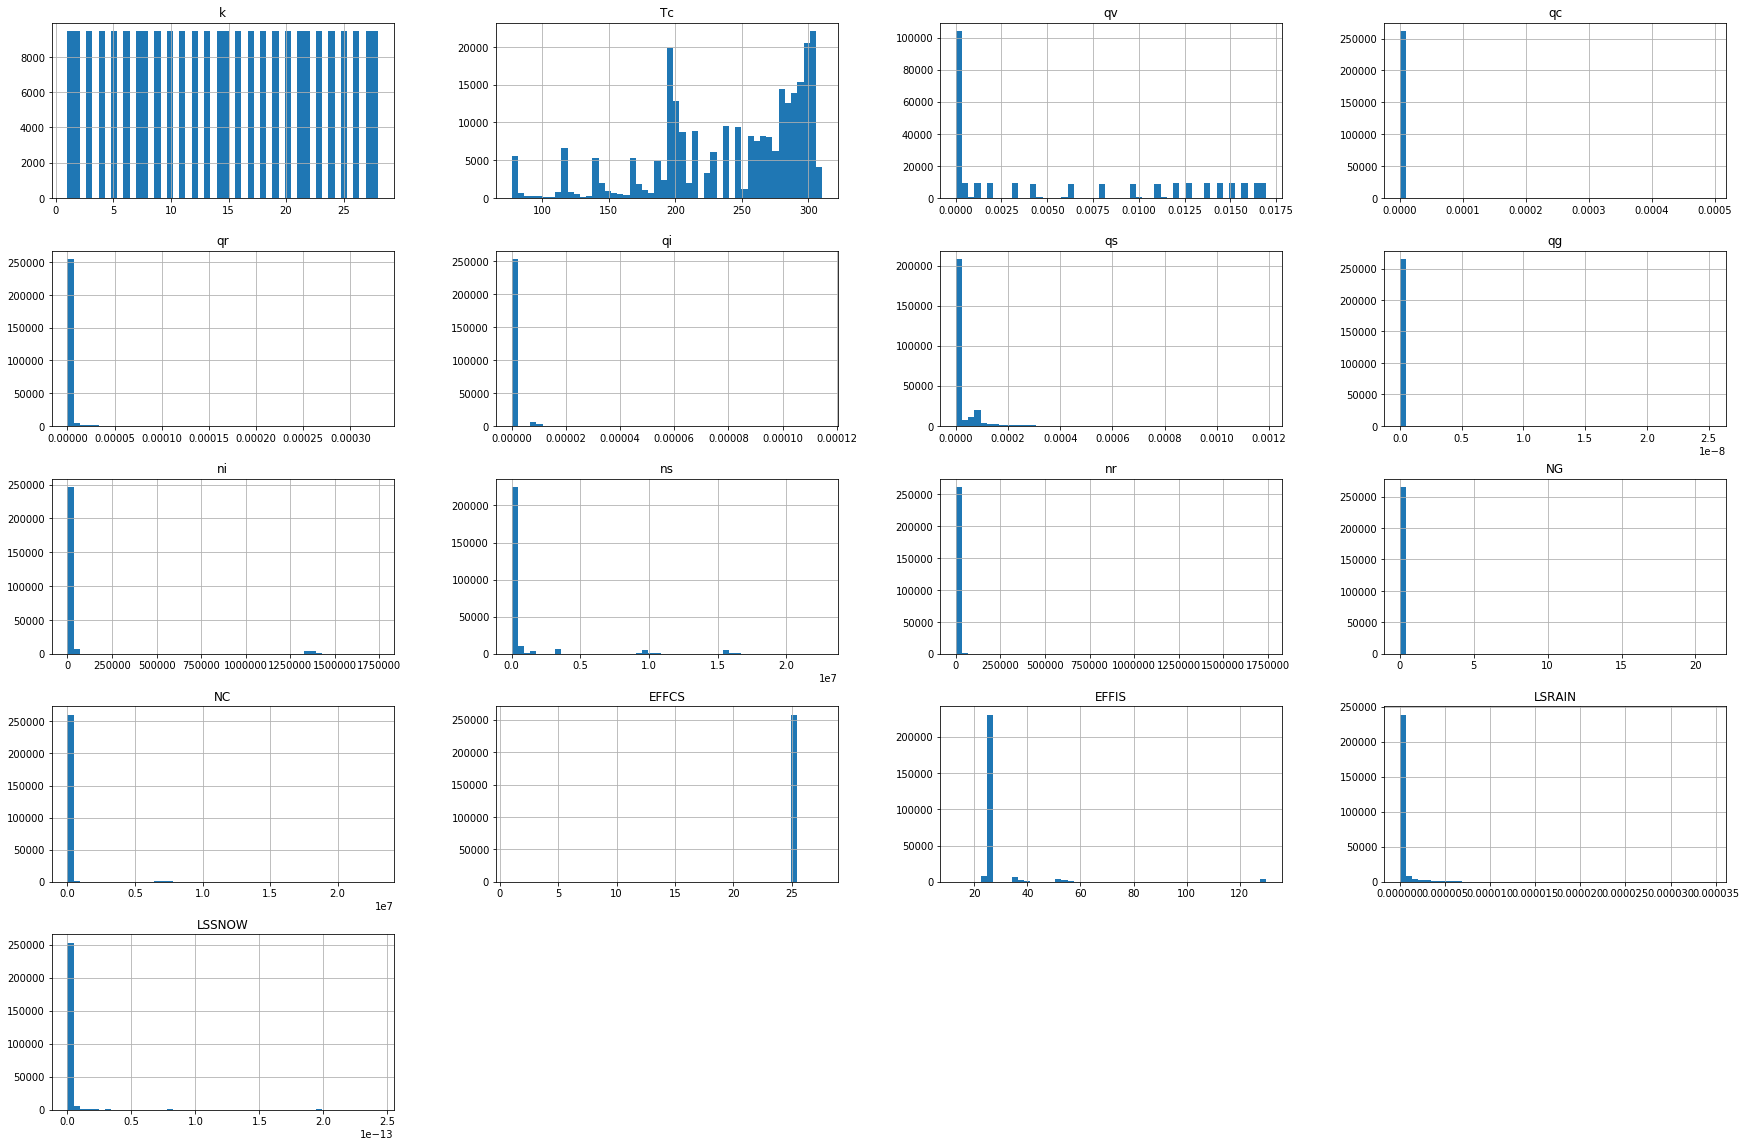

In [4]:
# Output Histograms

_ = original_output_df.hist(bins=50, figsize=(30, 20), xlabelsize=10)
#_ = validation_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

### Bloxpot das variáveis de entrada por níveis

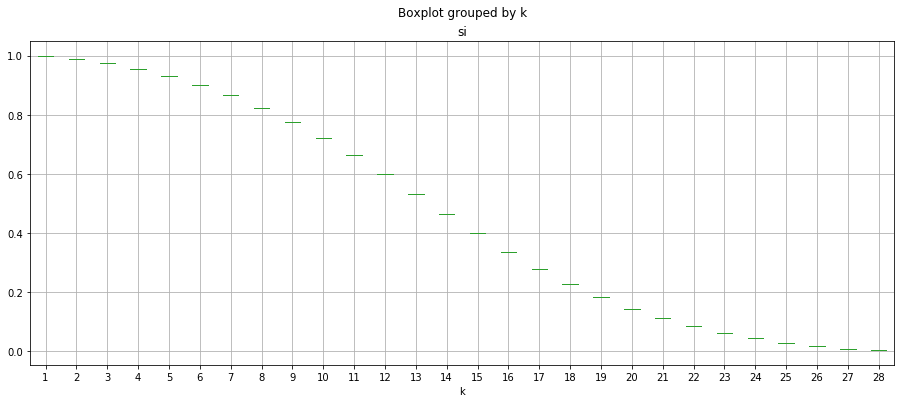

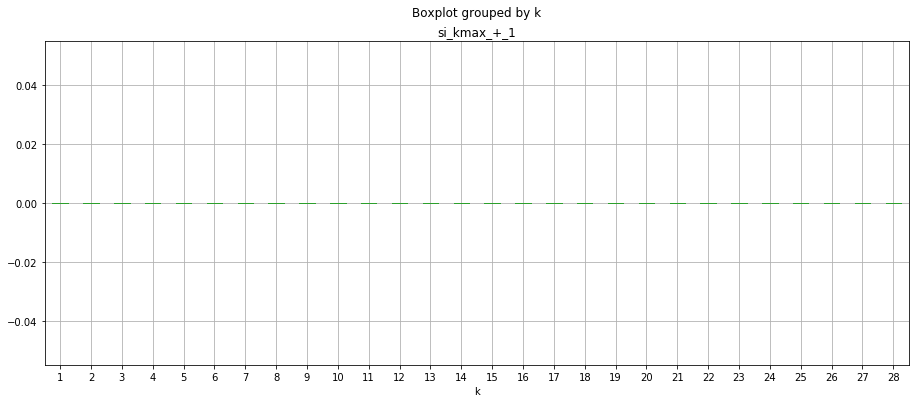

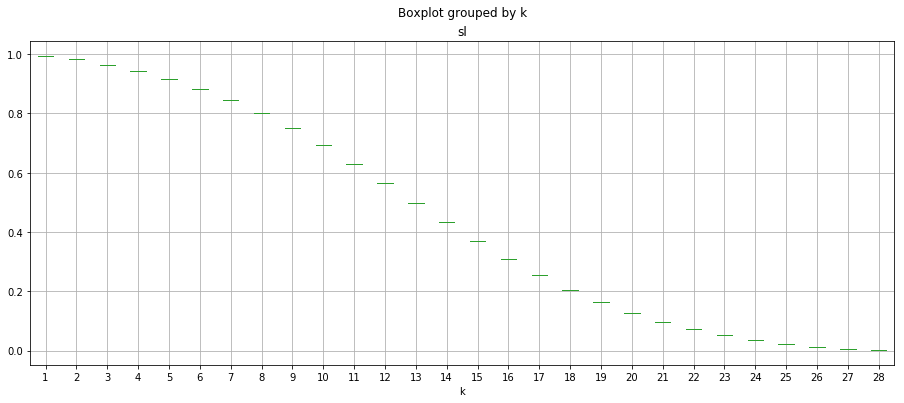

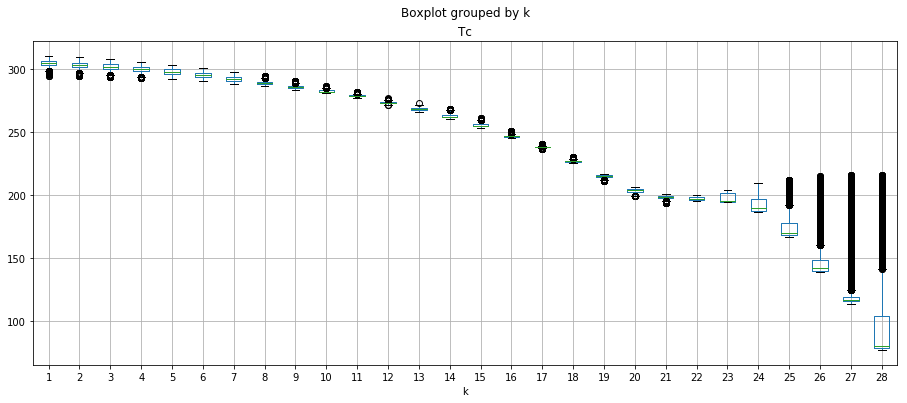

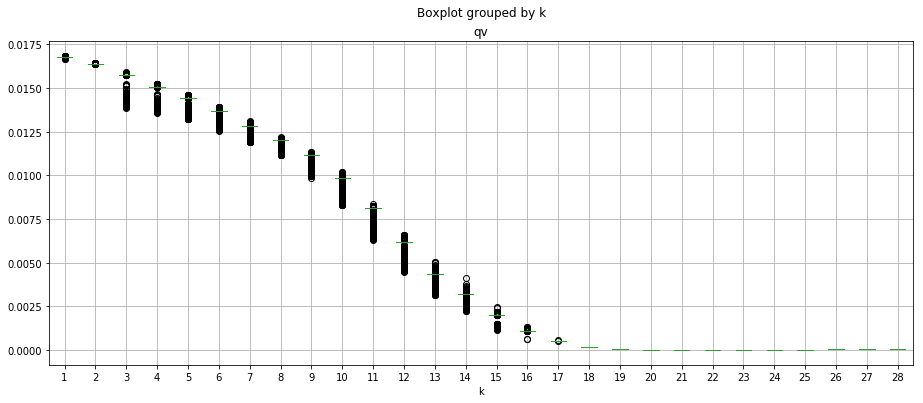

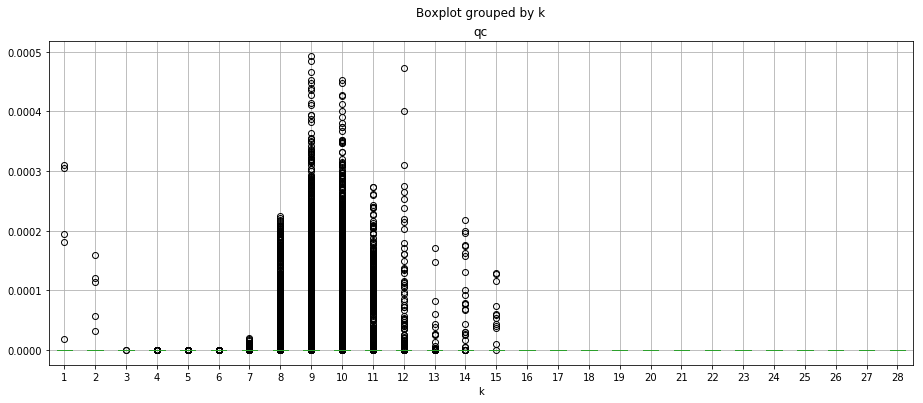

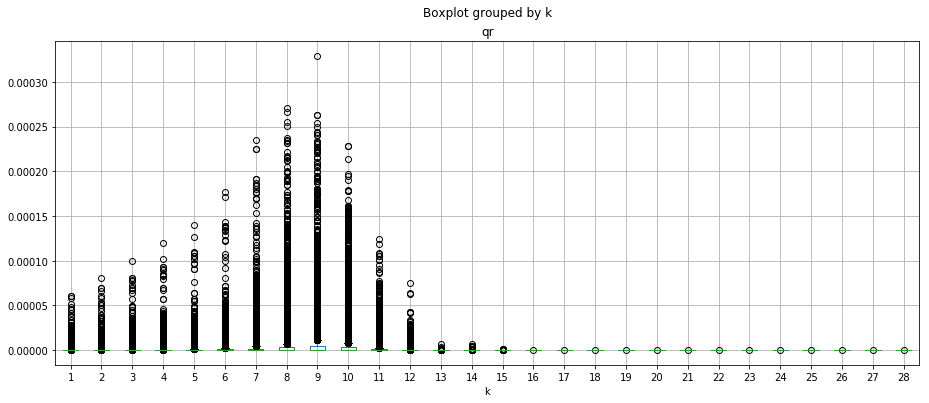

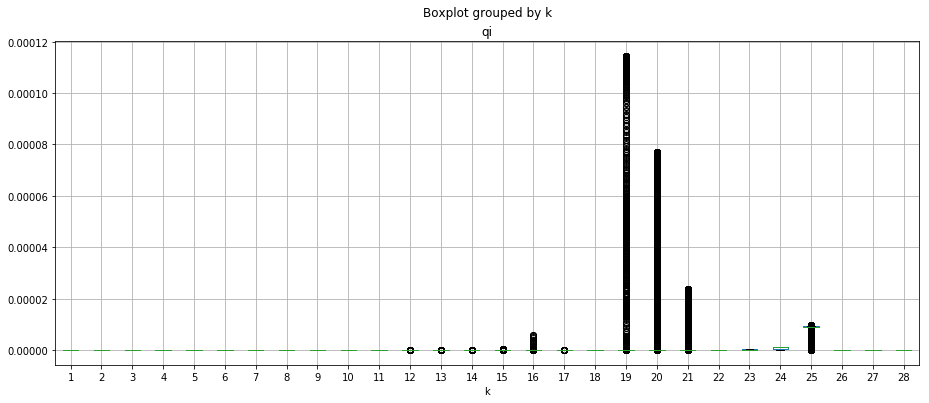

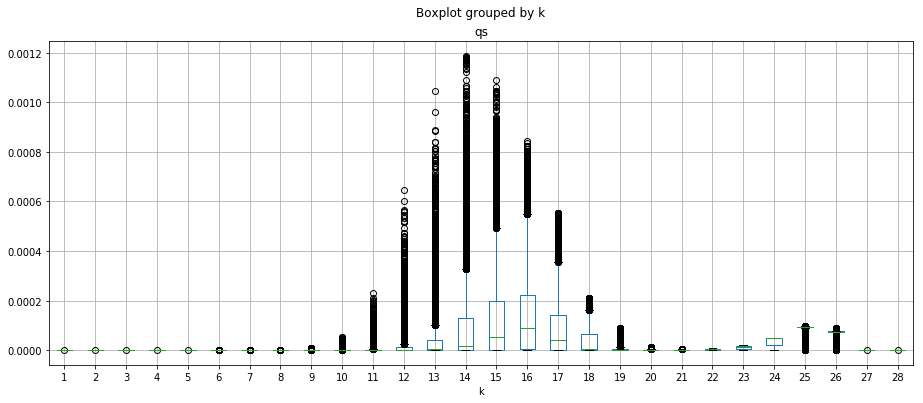

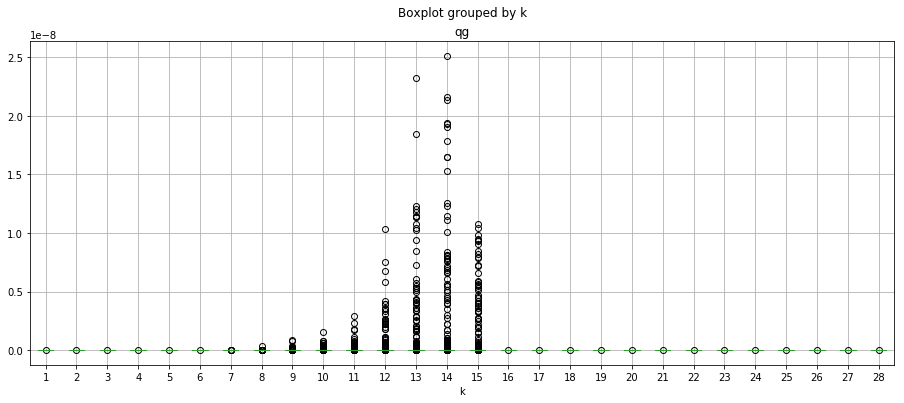

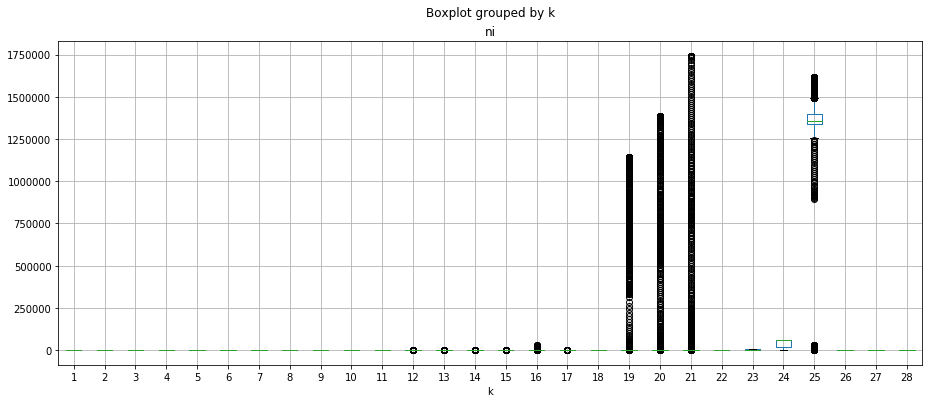

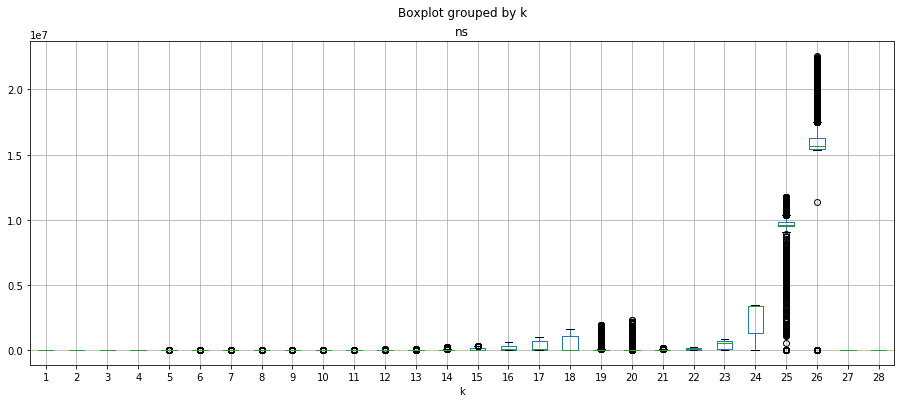

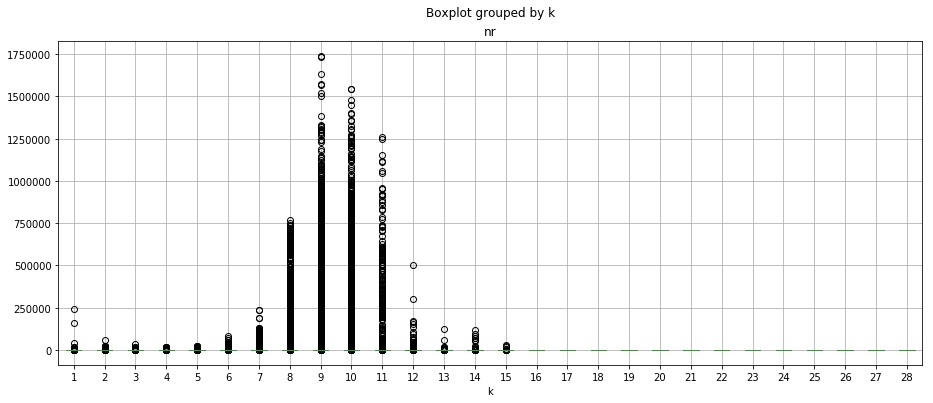

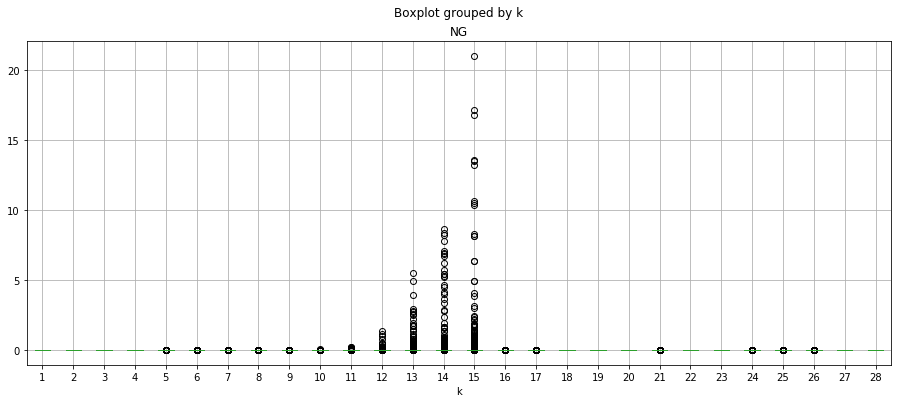

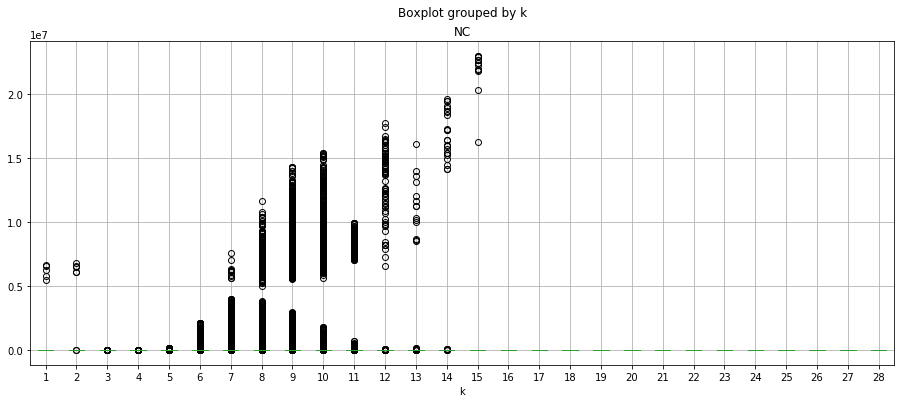

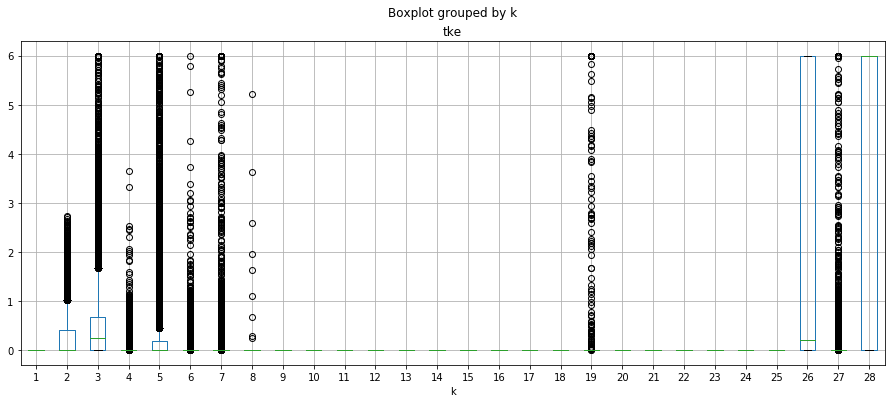

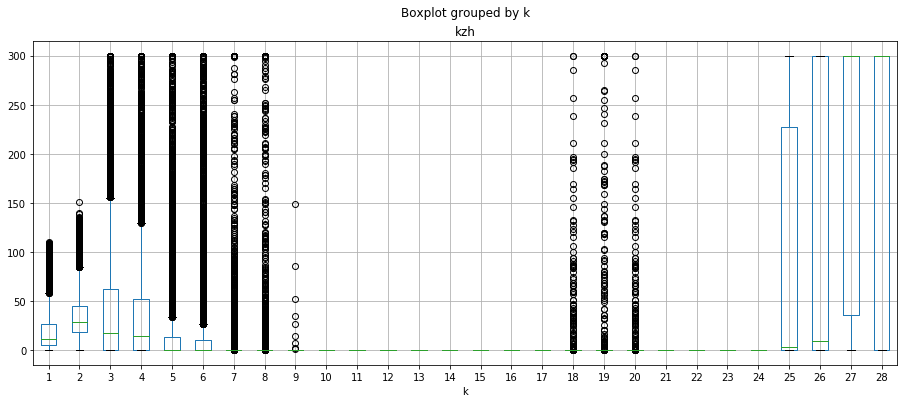

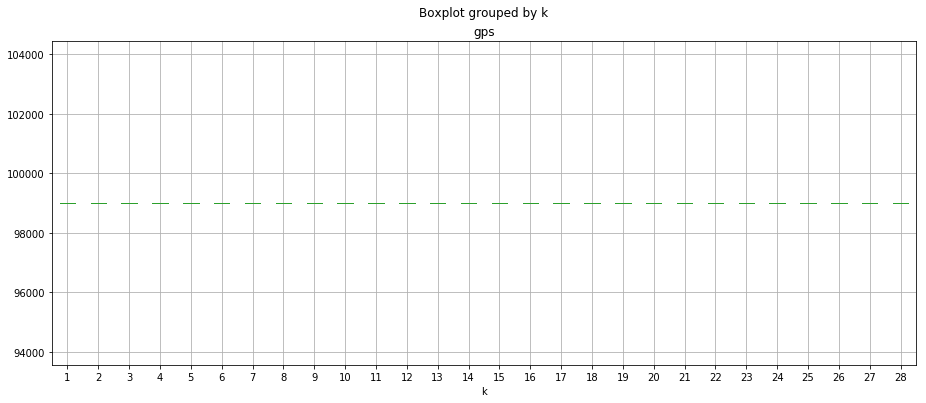

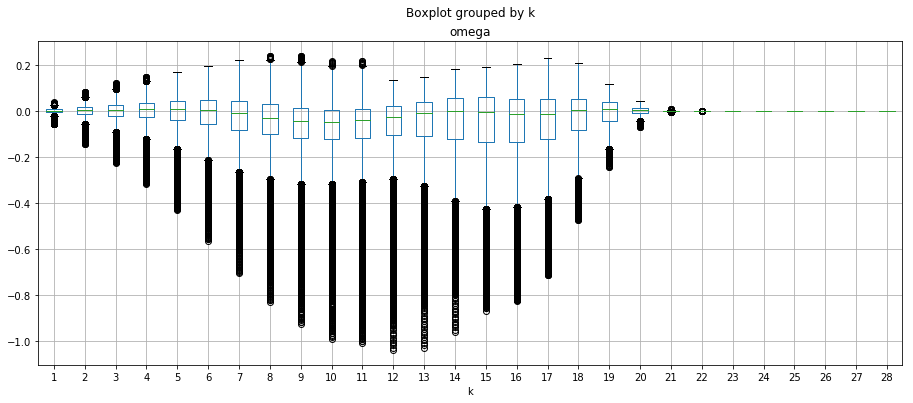

In [5]:
# Boxplot of variables through levels

for key in original_input_df.columns.tolist():
    if key == "k": continue
    # plt.subplot(6, 2, idx_plot)
    original_input_df.boxplot(column=key, by="k", figsize=(15, 6))
plt.show()


### Boxplot das variáveis de saída, por níveis

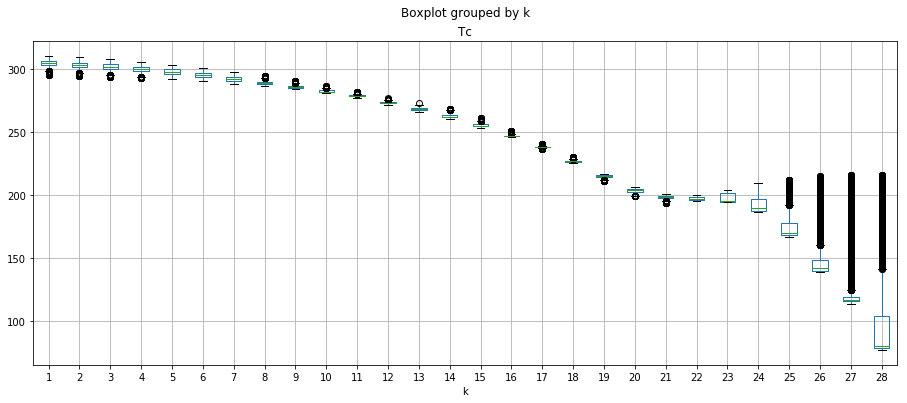

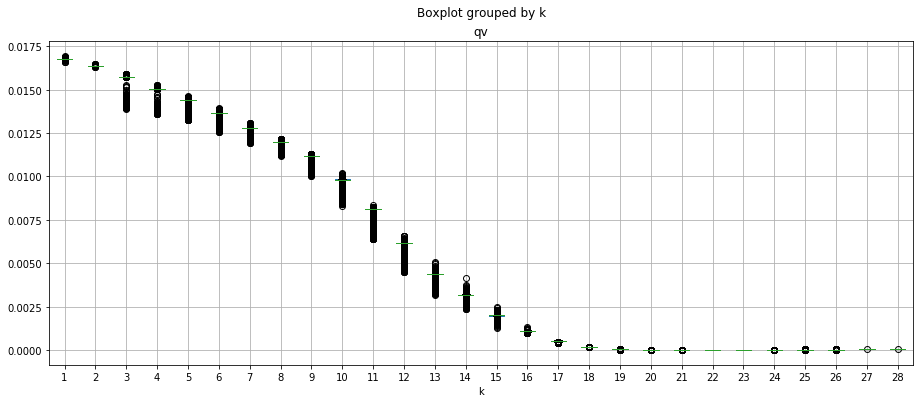

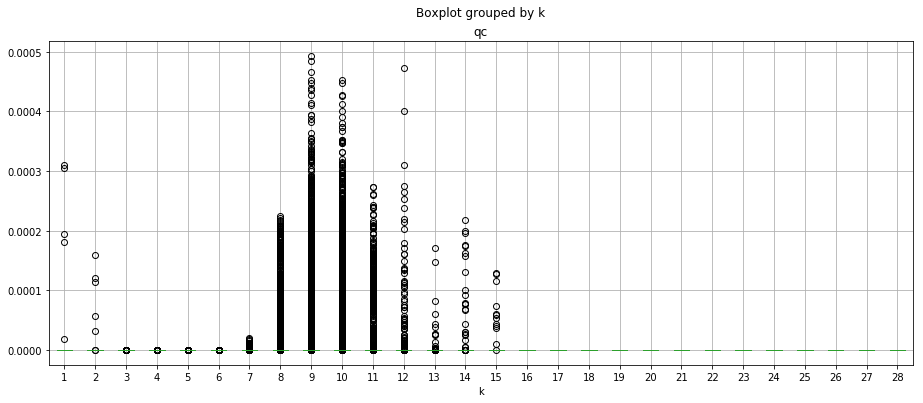

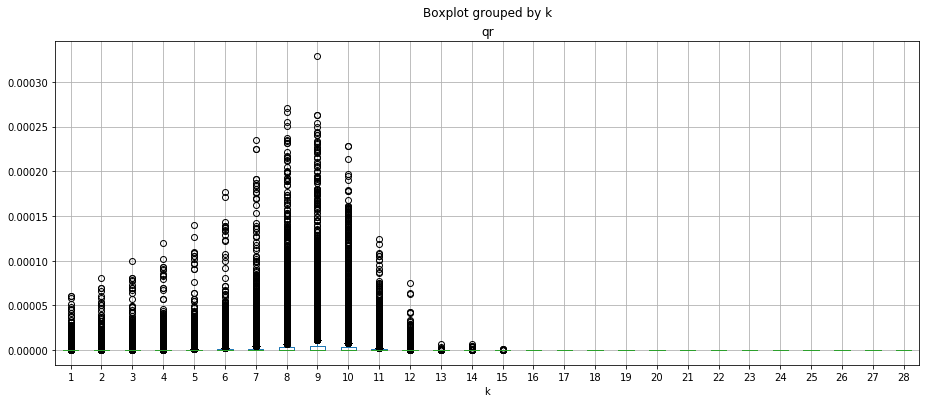

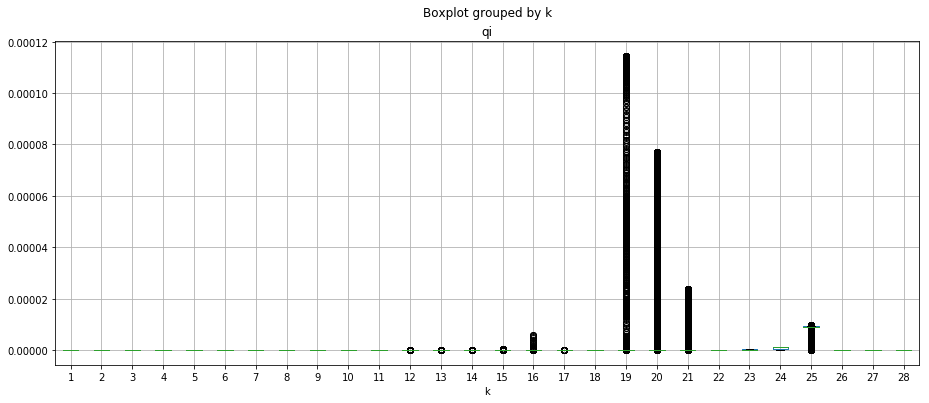

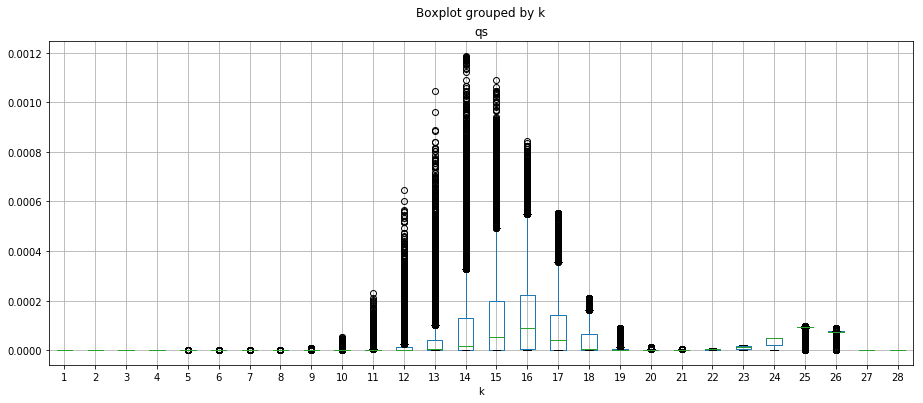

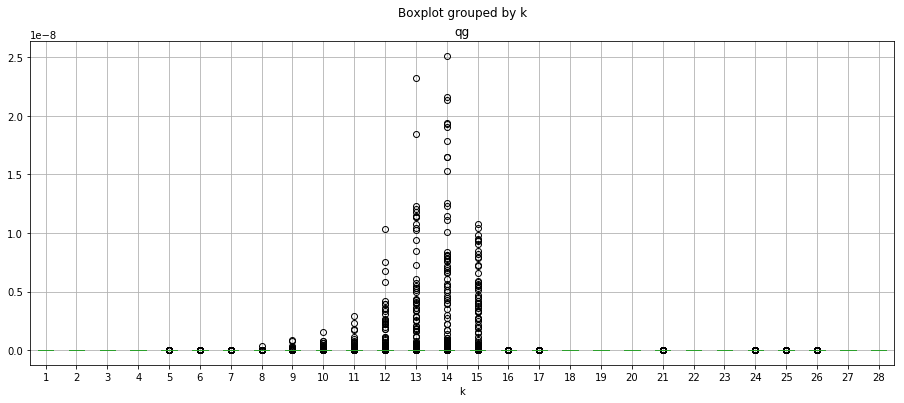

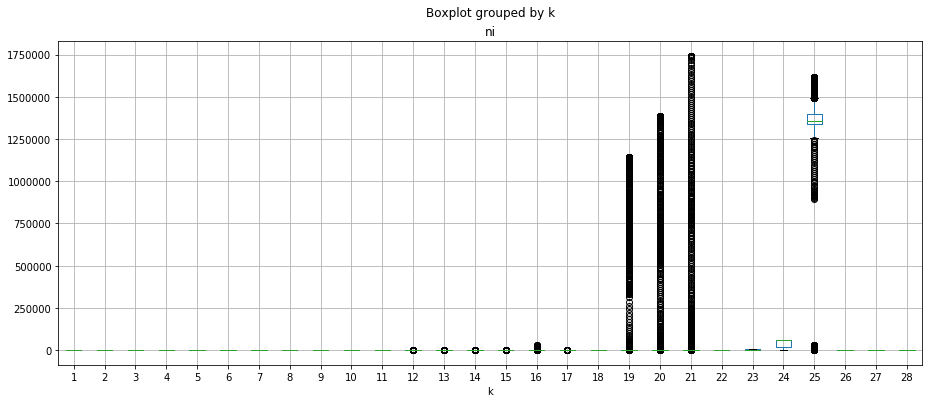

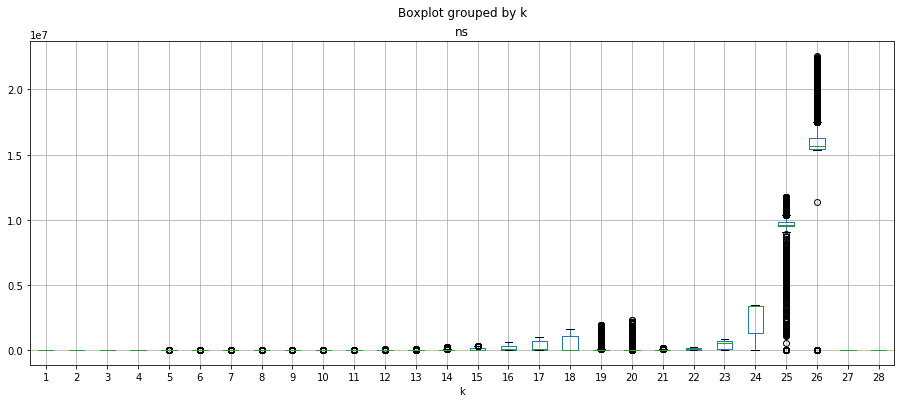

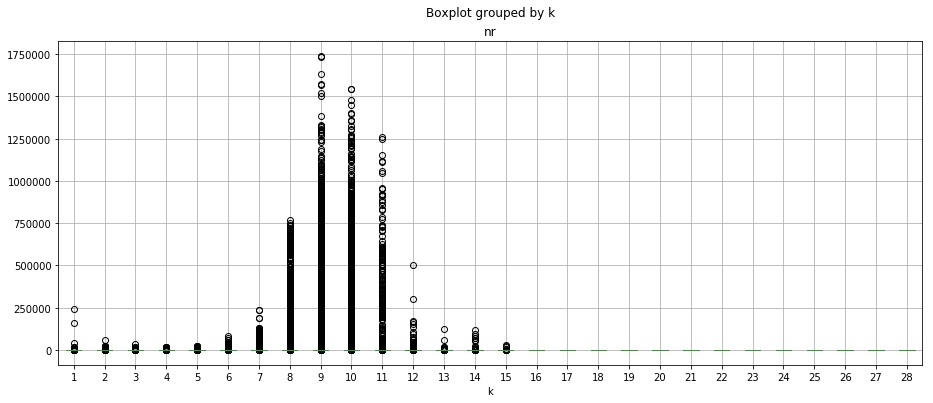

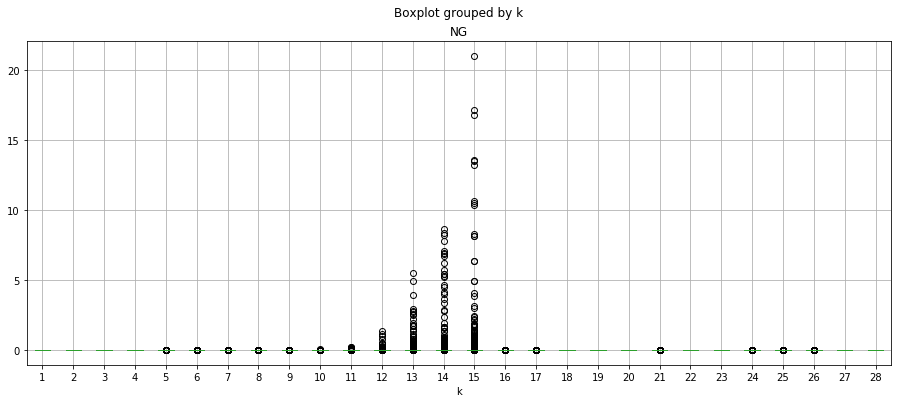

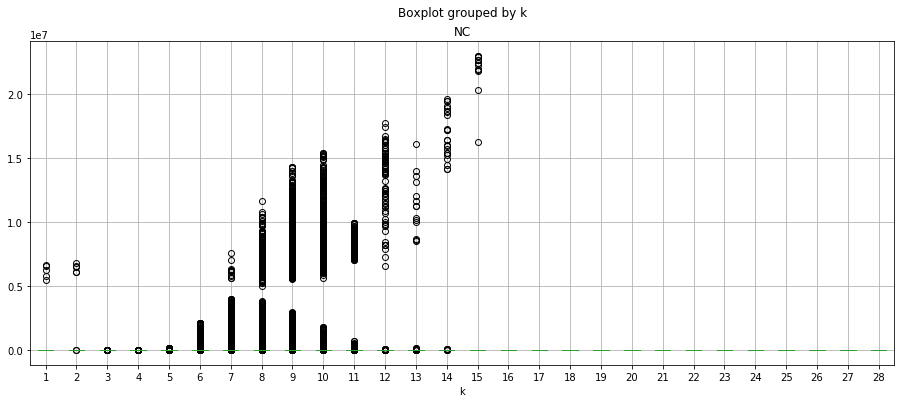

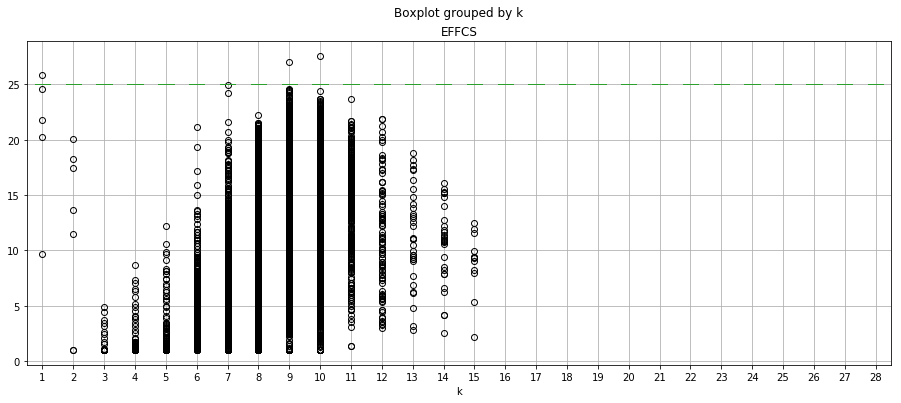

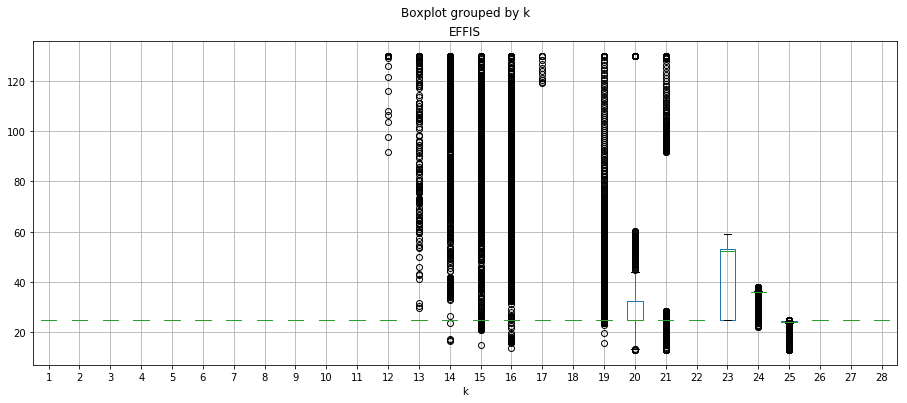

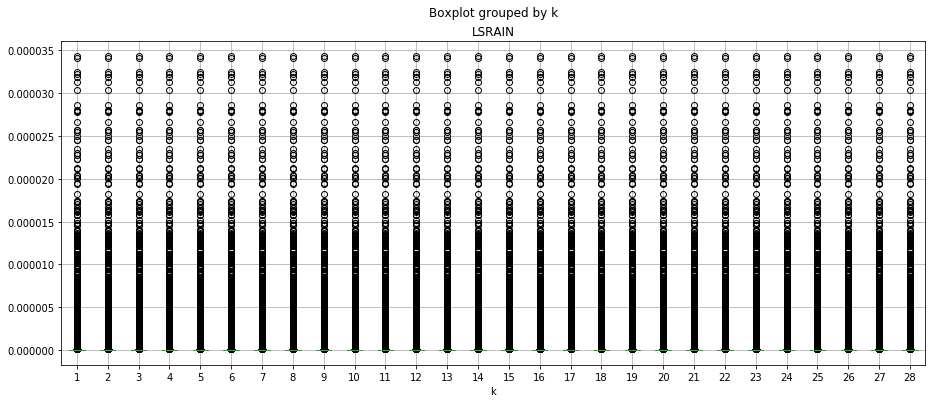

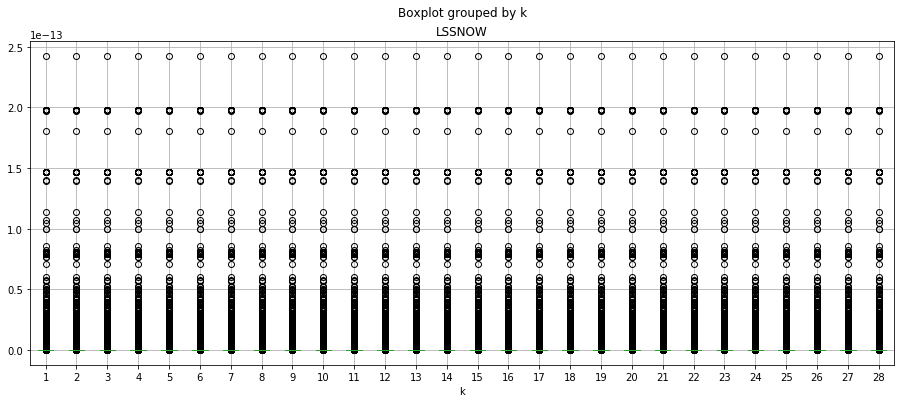

In [6]:
# Boxplot of variables through levels

for key in original_output_df.columns.tolist():
    if key == "k": continue
    # plt.subplot(6, 2, idx_plot)
    original_output_df.boxplot(column=key, by="k", figsize=(15, 6))
plt.show()

### Gráfico de perfil vertical das variáves de entrada em 3 timesteps

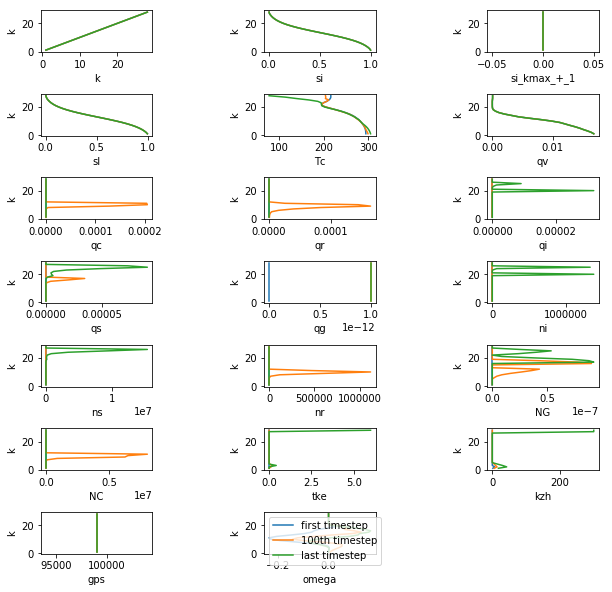

In [7]:
# Plot the vertical levels of first, 100th and last timestep

first_timestep_input_df = original_input_df.head(28)
med_timestep_input_df = original_input_df.loc[2800:2800+27]
last_timestep_input_df = original_input_df.tail(28)

idx_plot = 1
plt.figure(figsize=(10, 10))
for key in last_timestep_input_df.columns.tolist():
    plt.subplot(7, 3, idx_plot)
    plt.ylabel("k")
    plt.xlabel(key)
    plt.plot(first_timestep_input_df[key], first_timestep_input_df[["k"]], label="first timestep")
    plt.plot(med_timestep_input_df[key], med_timestep_input_df[["k"]], label="100th timestep")
    plt.plot(last_timestep_input_df[key], last_timestep_input_df[["k"]], label="last timestep")
    idx_plot += 1
plt.legend(loc="upper left")
plt.subplots_adjust(hspace=1, wspace=1)
plt.show()

first_timestep_output_df = original_output_df.head(28)
med_timestep_output_df = original_output_df.loc[2801:2801+27]
last_timestep_output_df = original_output_df.tail(28)

# idx_plot = 1
# for key in last_timestep_output_df.columns.tolist():
#     plt.subplot(4, 6, idx_plot)
#     plt.ylabel("k")
#     plt.xlabel(key)
#     plt.title("Output x Level")
#     plt.plot(first_timestep_output_df[key], first_timestep_output_df[["k"]], label="first timestep")
#     plt.plot(med_timestep_output_df[key], med_timestep_output_df[["k"]], label="100th timestep")
#     plt.plot(last_timestep_output_df[key], last_timestep_output_df[["k"]], label="last timestep")
#     plt.legend()
# plt.show()

## Pré-processando a entrada (exemplos) e saídas (metas)
- Selecionamos as primeiras variáveis de entrada e saída que serão usadas no treinamento e na validação;
- também podemos criar novas variáveis como um composto de variáveis

In [8]:
def preprocess_features(input_df):
  """Prepares input features input_df

  Args:
    input data frame: A Pandas DataFrame expected to contain data from input data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
# All input variables
# "k", "si", "si_kmax_+_1", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "gps", "omega"    
  selected_features = input_df[
    [
    "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"    
    ]]
  processed_features = selected_features.copy()
  return processed_features


def preprocess_targets(output_df):
  """Prepares target features (i.e., labels) from output_df

  Args:
    output_df: A Pandas DataFrame expected to contain data from output data set.
  Returns:
    A DataFrame that contains the target features.
  """
# All output variables
# "k", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"
  output_targets = output_df [
      [
      "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"
      ]
  ]
  return output_targets


# execute the pre processing
all_examples = preprocess_features(input_df)
all_targets = preprocess_targets(output_df)


### Funções de normalização

In [9]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

In [10]:
# Different normalilzation functions

def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

### Normalização da base usando escala linear

Normalização das entradas para a escala -1, 1. para os primeiros testes

Como regra geral, o NN treina melhor quando os recursos de entrada estão aproximadamente na mesma escala.

Isso ajuda o NN a não ficar preso em etapas que são muito grandes em uma dimensão ou muito pequenas em outra.


In [11]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  #
  # Your code here: normalize the inputs.
  #
    # Convert pandas data into a dict of np arrays.
#   processed_features = pd.DataFrame()
  processed_features = examples_dataframe.copy()
  for key,value in dict(examples_dataframe).items():
    processed_features[key] = linear_scale(value)
  return processed_features



#### Boxplot das variáveis de entrada linearmente normalizadas

All normalized examples summary:


,k,si,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,omega
count,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000
mean,-0.000000,-0.066812,-0.096078,0.405352,-0.307050,-0.993669,-0.991981,-0.983858,-0.950240,-0.999590,-0.929857,-0.907674,-0.994743,-0.999829,-0.989400,-0.909784,-0.809200,0.574896
std,0.598353,0.729800,0.726886,0.493977,0.753155,0.065028,0.051665,0.108332,0.141149,0.015516,0.319498,0.300784,0.058702,0.010571,0.085237,0.381426,0.525719,0.194582
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.500000,-0.798840,-0.820599,0.047516,-0.994740,-1.000000,-1.000000,-1.000000,-1.000000,-0.999920,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.999533,0.573916
50%,-0.000000,-0.139702,-0.197953,0.570986,-0.731952,-1.000000,-1.000000,-1.000000,-0.999950,-0.999920,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.999533,0.624689
75%,0.500000,0.667721,0.630182,0.825954,0.435062,-1.000000,-1.000000,-1.000000,-0.976032,-0.999920,-1.000000,-0.996237,-1.000000,-1.000000,-1.000000,-1.000000,-0.999533,0.645794
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


All normalized targets summary:


,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
count,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000
mean,0.405368,-0.311562,-0.993669,-0.991981,-0.983855,-0.950238,-0.999653,-0.929845,-0.907664,-0.994743,-0.999829,-0.989400,0.773415,-0.736271,-0.972897,-0.983997
std,0.493932,0.748534,0.065028,0.051665,0.108337,0.141150,0.015518,0.319524,0.300797,0.058702,0.010571,0.085237,0.189538,0.249995,0.122947,0.112701
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.047502,-0.996101,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.804039,-0.794872,-1.000000,-0.999988
50%,0.572248,-0.719032,-1.000000,-1.000000,-1.000000,-0.999950,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.804039,-0.794872,-0.999997,-0.999837
75%,0.825897,0.426582,-1.000000,-1.000000,-1.000000,-0.976027,-0.999980,-1.000000,-0.996237,-1.000000,-1.000000,-1.000000,0.804039,-0.794872,-0.997988,-0.998695
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


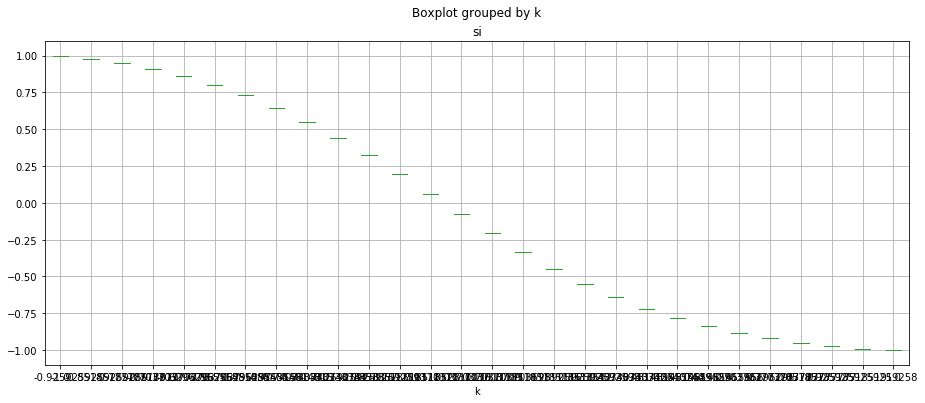

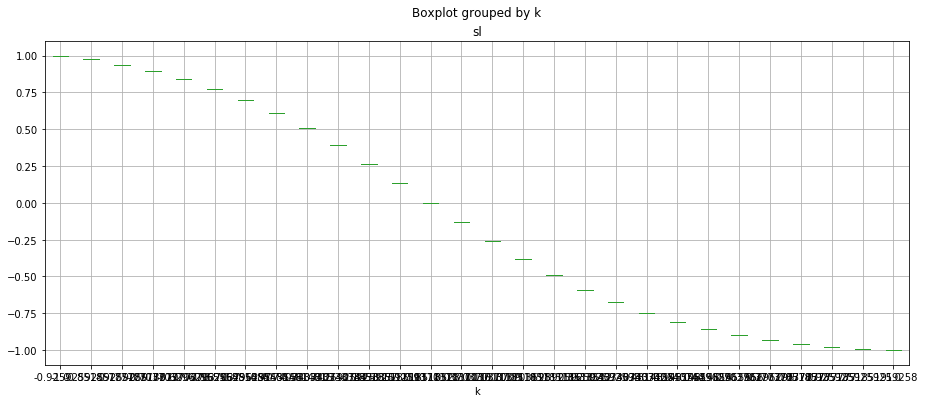

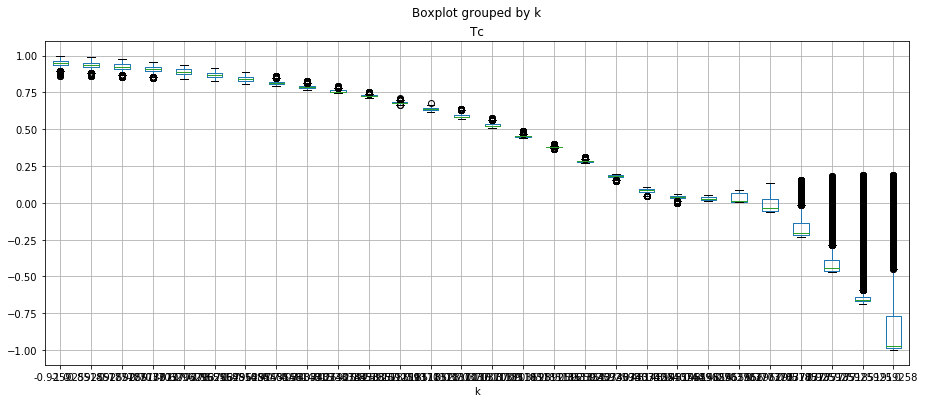

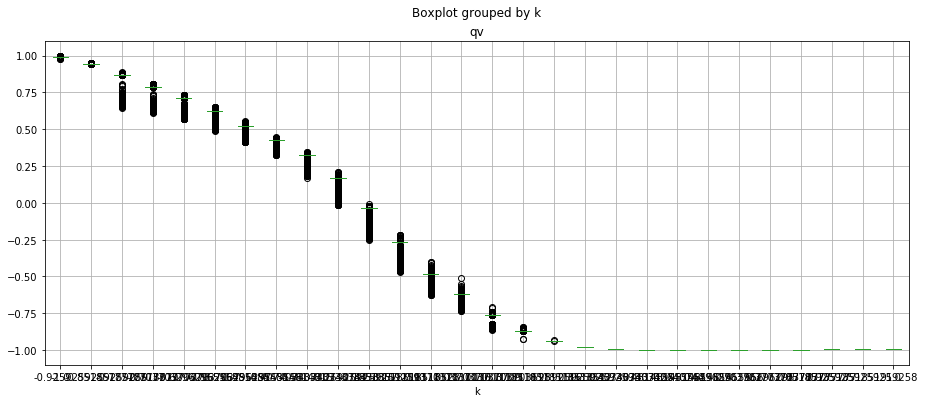

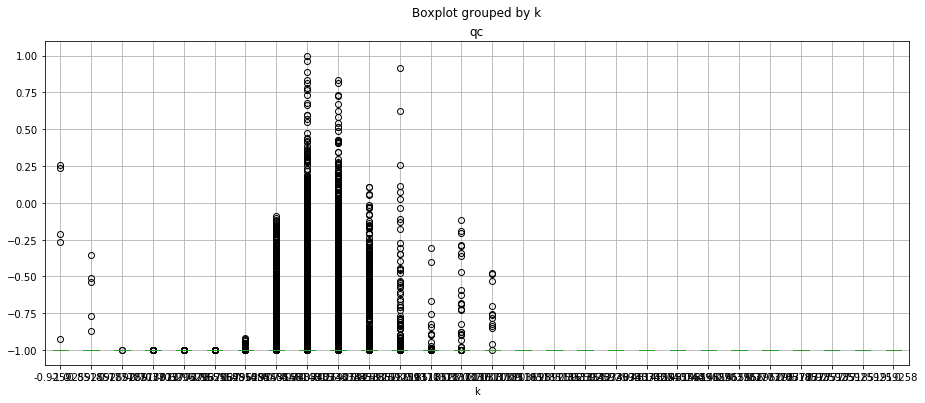

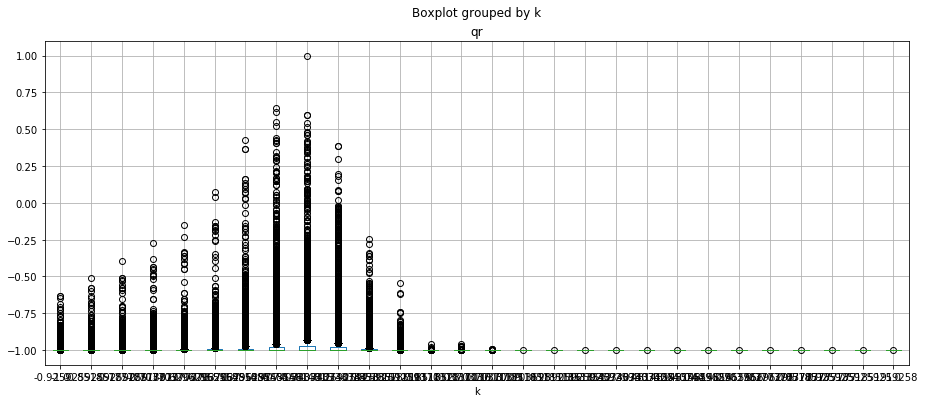

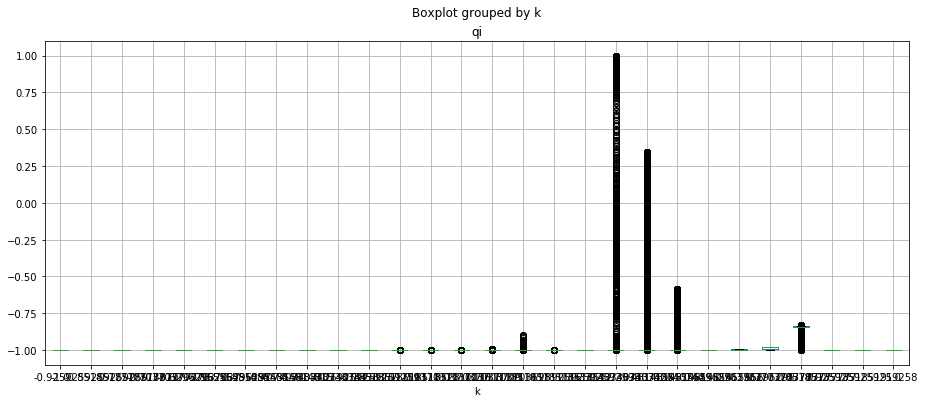

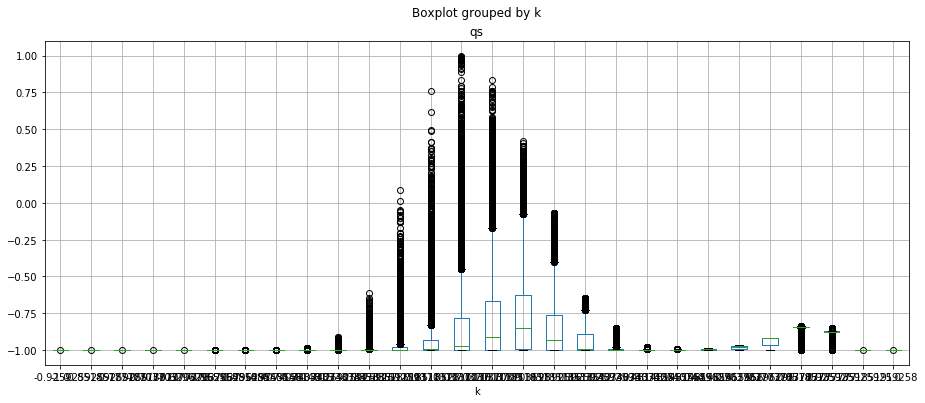

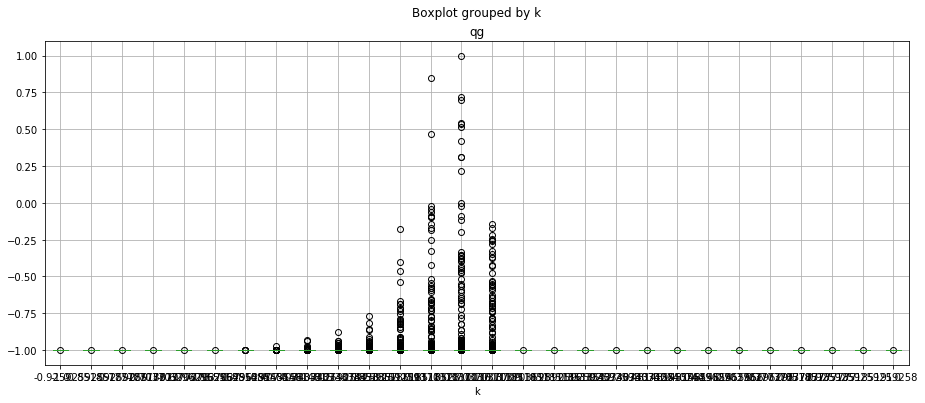

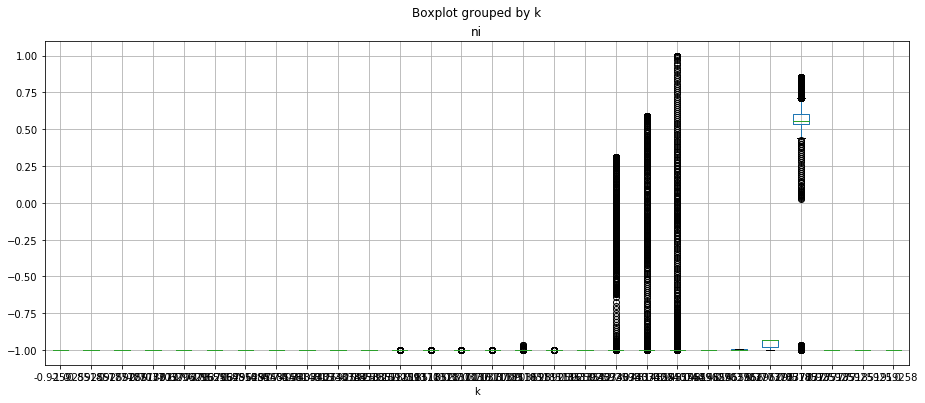

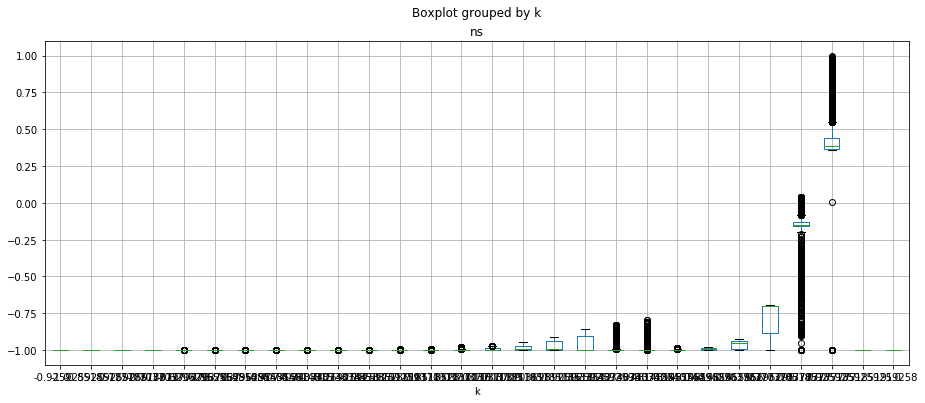

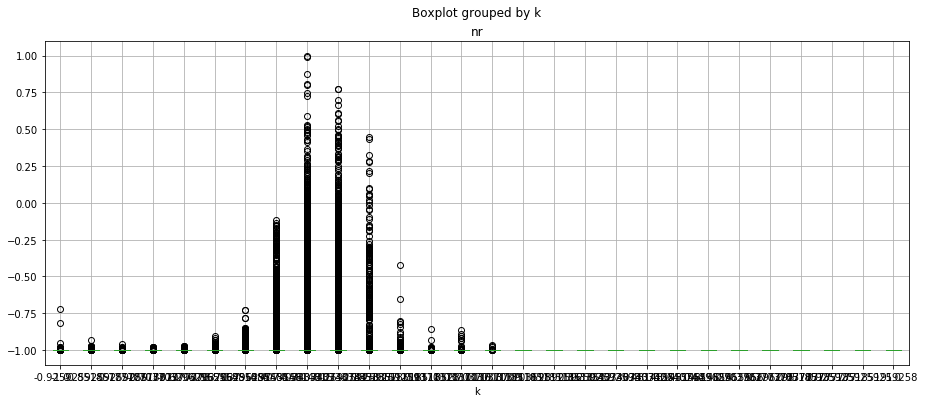

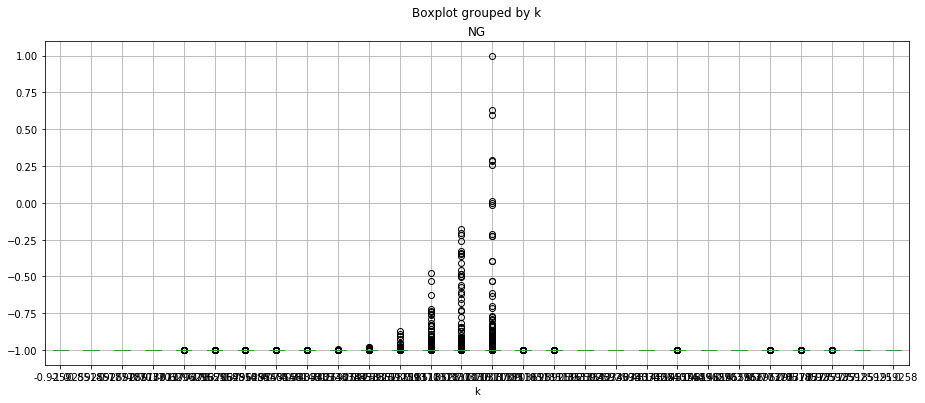

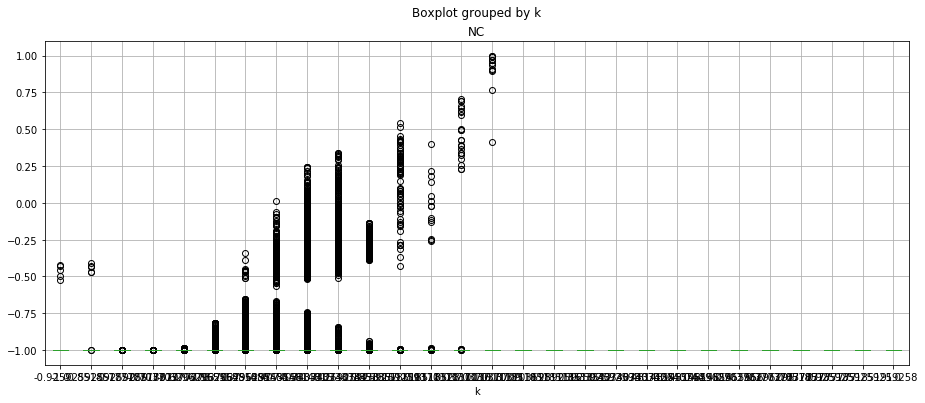

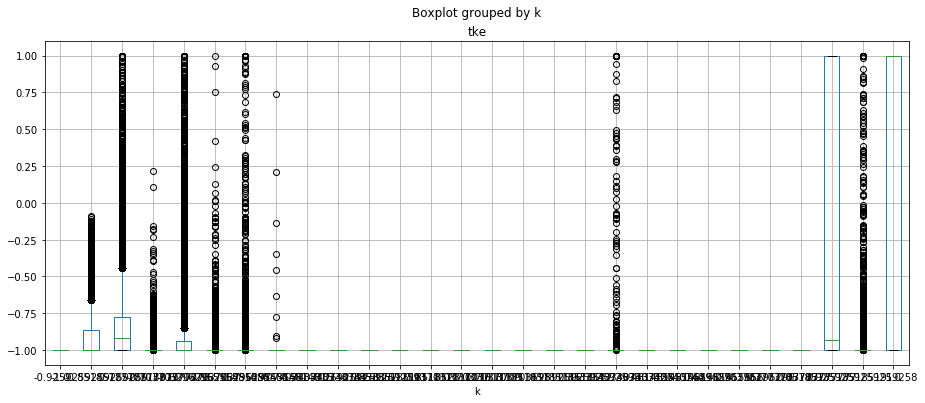

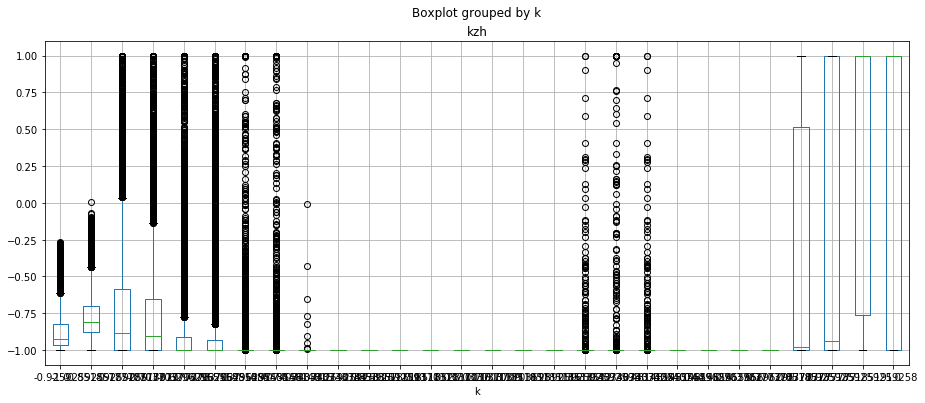

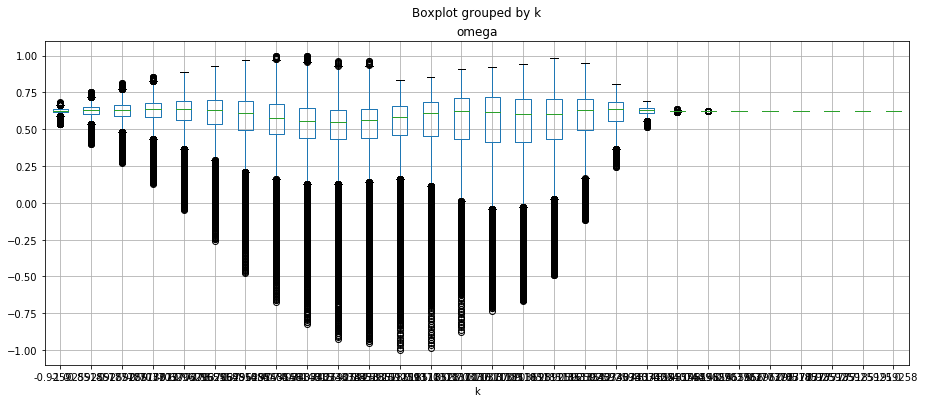

In [12]:
#
# code below just to show
#

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

print("All normalized examples summary:")
display.display(normalized_all_examples.describe())

print("All normalized targets summary:")
display.display(normalized_all_targets.describe())


# Boxplot of variables through levels
for key in normalized_all_examples.columns.tolist():
    if key == "k": continue
    # plt.subplot(6, 2, idx_plot)
    normalized_all_examples.boxplot(column=key, by="k", figsize=(15, 6))
plt.show()

### Normalização da base usando diferentes escalas para cada variável

- Diferentes normalizações por variável, como linear, logarítimica e z-score


In [13]:
def normalize_examples(examples_dataframe):
  # "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"
  processed_features = pd.DataFrame()

  if len(examples_dataframe["k"]) > 0:
    processed_features["k"] = examples_dataframe["k"]

  for m_var in [ "si", "sl", "Tc", "qv"]:
    processed_features[m_var] = linear_scale(examples_dataframe[m_var])

  for m_var in [ "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh"]:
    processed_features[m_var] = log_normalize(examples_dataframe[m_var])

  processed_features["omega"] = z_score_normalize(examples_dataframe["omega"])
  # processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
    
  return processed_features


#### Boxplot das variáveis de entrada com diferentes normalizações

All normalized examples summary:


,k,si,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,omega
count,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000
mean,14.500000,-0.066812,-0.096078,0.405352,-0.307050,0.000002,0.000001,0.000001,0.000030,0.000000,1.225962,5.244949,0.761647,0.000743,0.403765,0.104675,1.029327,0.000000
std,8.077762,0.729800,0.726886,0.493977,0.753155,0.000016,0.000009,0.000006,0.000084,0.000000,3.588118,5.950812,2.130680,0.031000,2.365943,0.391102,1.804910,1.000000
min,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029559,-8.093726
25%,7.750000,-0.798840,-0.820599,0.047516,-0.994740,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095310,-0.005039
50%,14.500000,-0.139702,-0.197953,0.570986,-0.731952,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.303671,0.000000,0.000000,0.000000,0.000000,0.095310,0.255893
75%,21.250000,0.667721,0.630182,0.825954,0.435062,0.000000,0.000000,0.000000,0.000014,0.000000,0.000000,10.657978,0.000000,0.000000,0.000000,0.000000,0.095310,0.364360
max,28.000000,1.000000,1.000000,1.000000,1.000000,0.000493,0.000329,0.000115,0.001189,0.000000,14.371708,16.933672,14.369937,3.091543,16.950967,1.945910,5.707110,2.184698


All normalized targets summary:


,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
count,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000
mean,0.405368,-0.311562,-0.993669,-0.991981,-0.983855,-0.950238,-0.999653,-0.929845,-0.907664,-0.994743,-0.999829,-0.989400,0.773415,-0.736271,-0.972897,-0.983997
std,0.493932,0.748534,0.065028,0.051665,0.108337,0.141150,0.015518,0.319524,0.300797,0.058702,0.010571,0.085237,0.189538,0.249995,0.122947,0.112701
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.047502,-0.996101,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.804039,-0.794872,-1.000000,-0.999988
50%,0.572248,-0.719032,-1.000000,-1.000000,-1.000000,-0.999950,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.804039,-0.794872,-0.999997,-0.999837
75%,0.825897,0.426582,-1.000000,-1.000000,-1.000000,-0.976027,-0.999980,-1.000000,-0.996237,-1.000000,-1.000000,-1.000000,0.804039,-0.794872,-0.997988,-0.998695
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


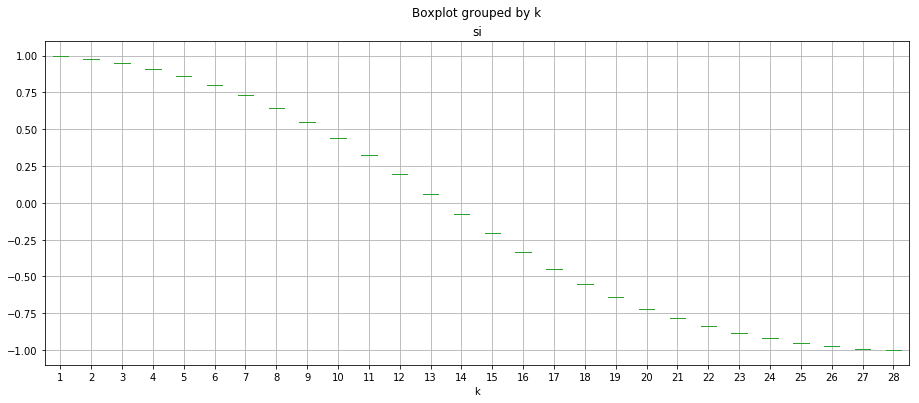

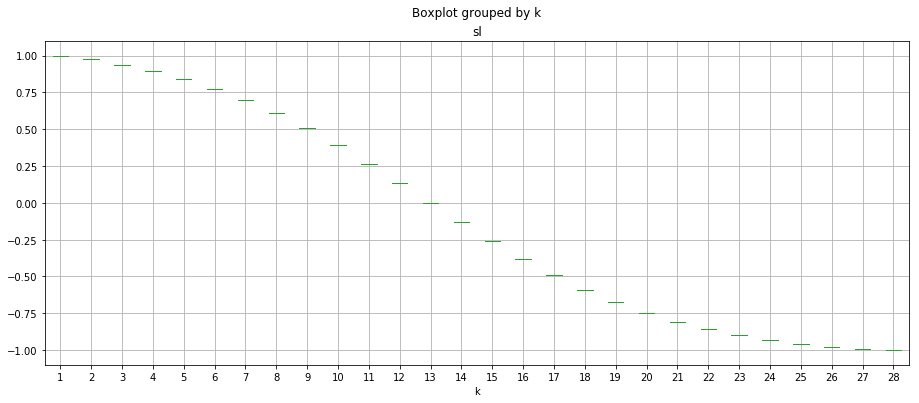

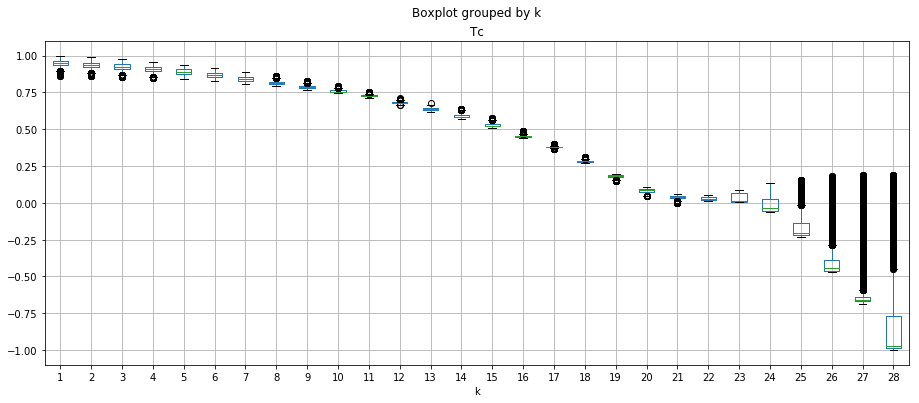

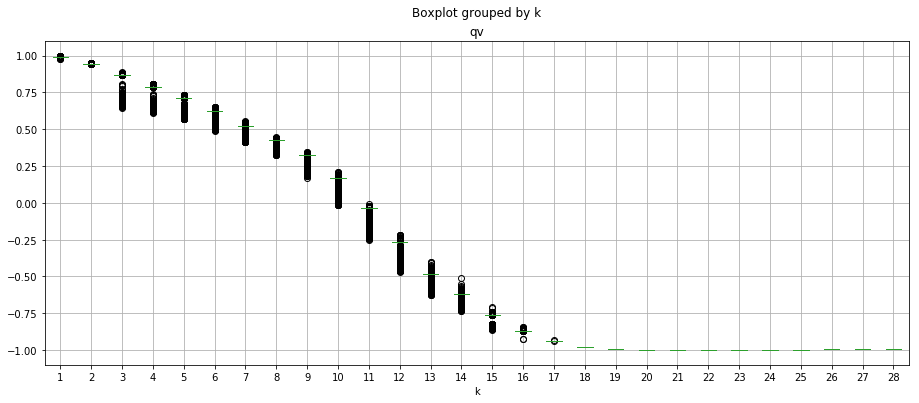

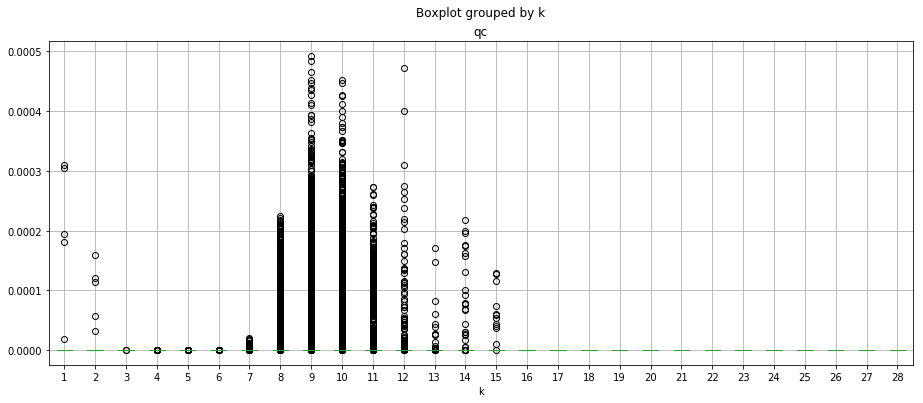

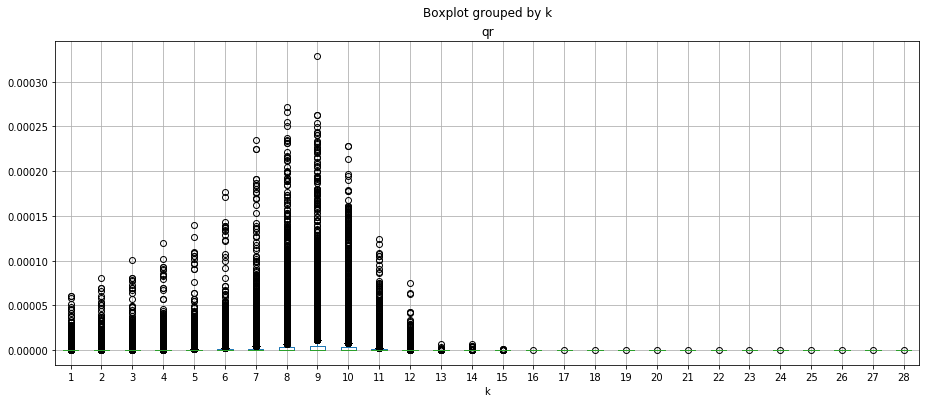

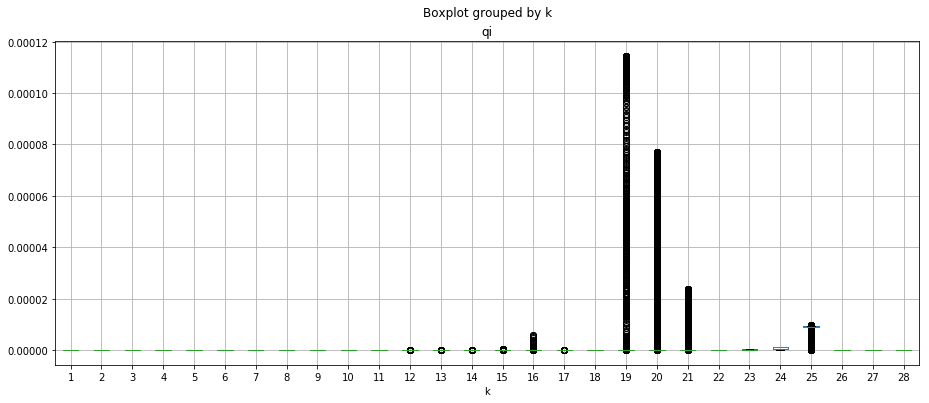

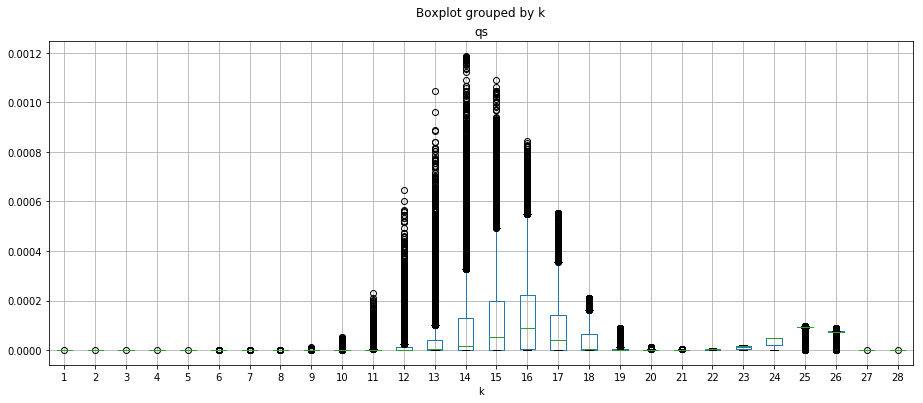

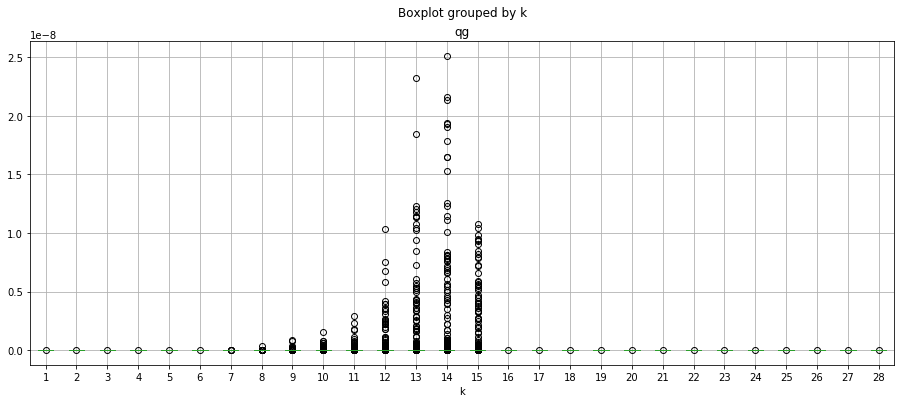

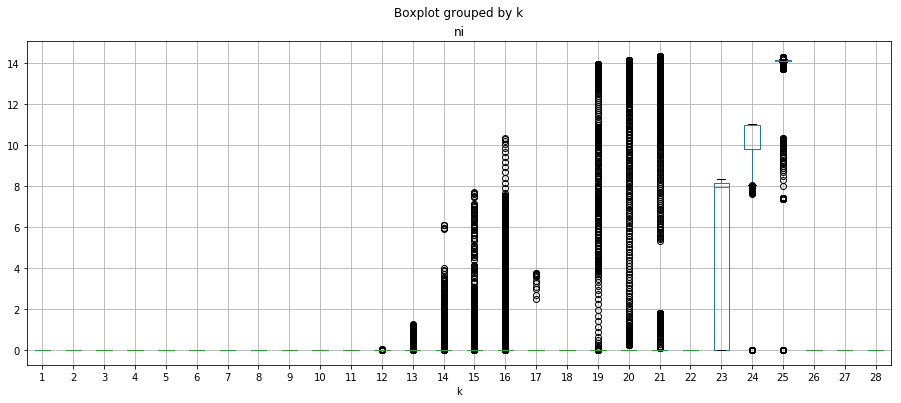

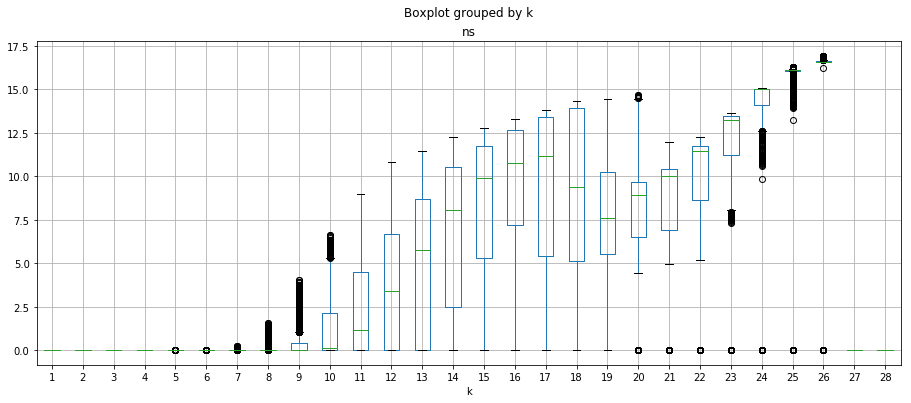

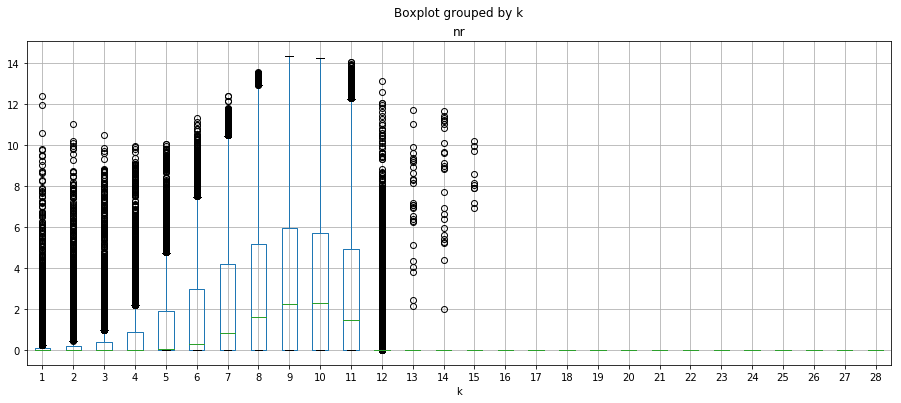

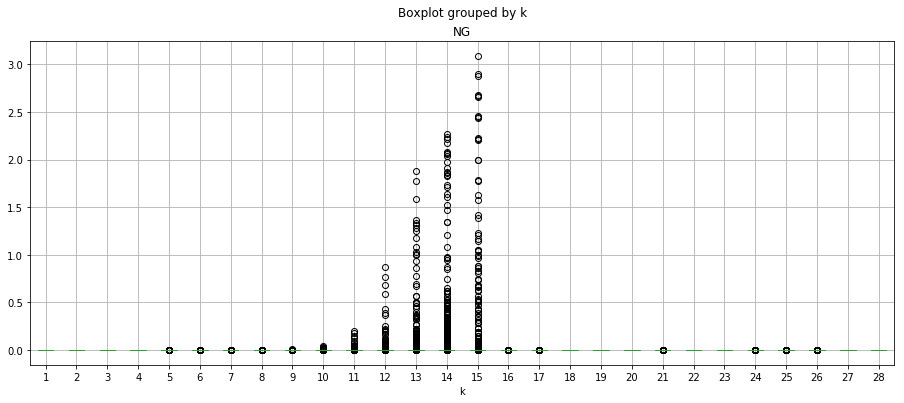

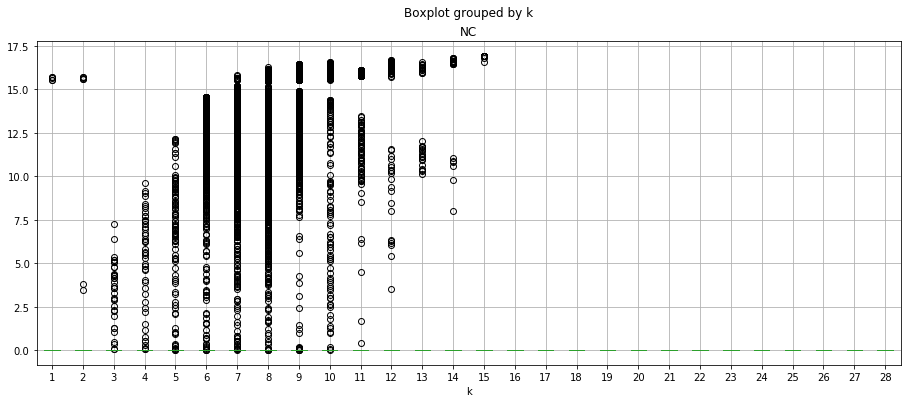

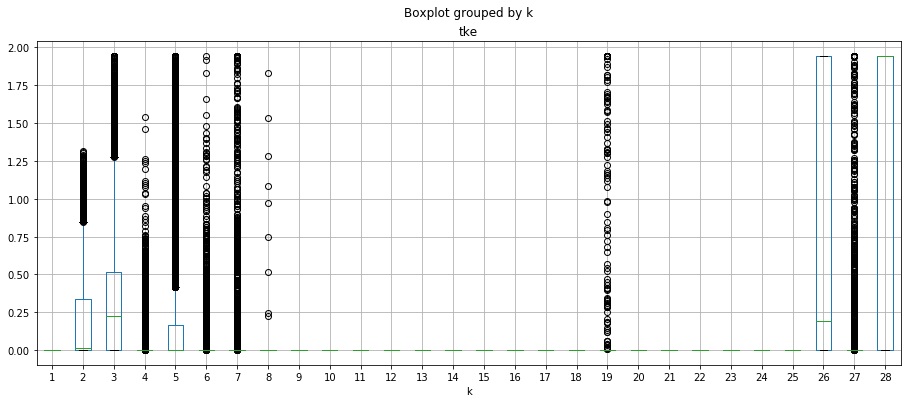

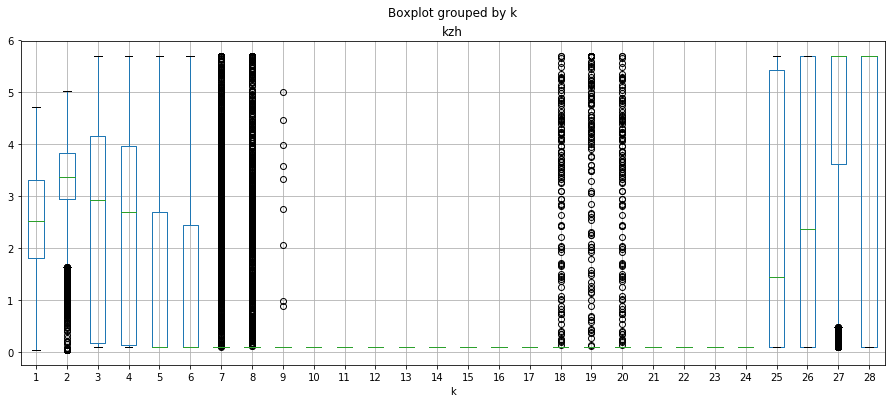

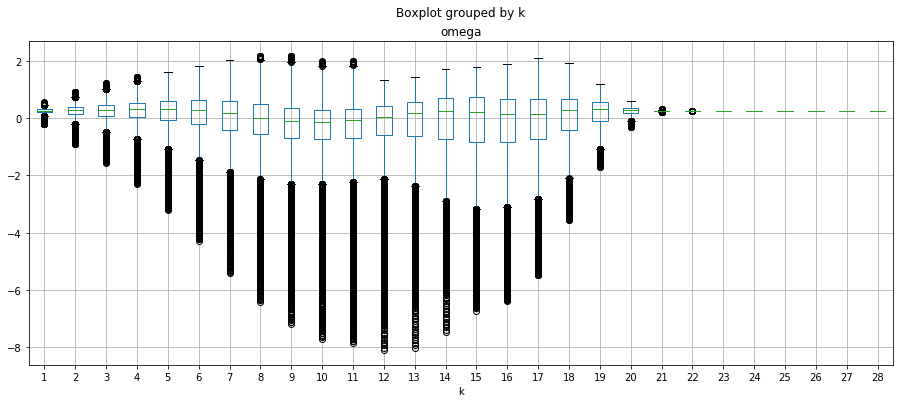

In [14]:

normalized_all_examples = normalize_examples(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

print("All normalized examples summary:")
display.display(normalized_all_examples.describe())

print("All normalized targets summary:")
display.display(normalized_all_targets.describe())


# Boxplot of variables through levels
for key in normalized_all_examples.columns.tolist():
    if key == "k": continue
    # plt.subplot(6, 2, idx_plot)
    normalized_all_examples.boxplot(column=key, by="k", figsize=(15, 6))
plt.show()

## Conjuntos de treinamento e validação

Exibe  o resumo de entrada e saída de conjuntos de treinamento e validação, para verificar a homogeneidade desses conjuntos


In [15]:
def get_70_percent_normalized_trainining_and_30_validation(normalized_all_examples, normalized_all_targets):
  # Choose the first 185828 (70%) (out of 265469) for training.
  normalized_training_examples = normalized_all_examples.head(185828)
  normalized_training_targets = normalized_all_targets.head(185828)

  # Choose the last 79641 (30%) (out of 265469) for validation.
  normalized_validation_examples = normalized_all_examples.tail(79641)
  normalized_validation_targets = normalized_all_targets.tail(79641)
  return normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets

def get_10_percent_normalized_trainining_and_10_validation(normalized_all_examples, normalized_all_targets):
  # Choose the first 26546 (10%) (out of 265469) for training.
  normalized_training_examples = normalized_all_examples.head(26546)
  normalized_training_targets = normalized_all_targets.head(26546)

  # Choose the last 26546 (10%) (out of 265469) for validation.
  normalized_validation_examples = normalized_all_examples.tail(26546)
  normalized_validation_targets = normalized_all_targets.tail(26546)
  return normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets


In [16]:
# Choose variables to train and validate
# Eliminate variables are not varying
# Separate 70% for training and 30# for validation

# # Choose the first 185828 (70%) (out of 265469) for training.
# training_examples = all_examples.head(185828)
# training_targets = all_targets.head(185828)

# # Choose the last 79641 (30%) (out of 265469) for validation.
# validation_examples = all_examples.tail(79641)
# validation_targets = all_targets.tail(79641)


# Choose the first 26546 (10%) (out of 265469) for training.
training_examples_tmp = all_examples.head(26546)
training_targets_tmp = all_targets.head(26546)

# Choose the last 26546 (10%) (out of 265469) for validation.
validation_examples_tmp = all_examples.tail(26546)
validation_targets_tmp = all_targets.tail(26546)


print("Training examples summary:")
display.display(training_examples_tmp.describe())

print("Validation examples summary:")
display.display(validation_examples_tmp.describe())

print("Training targets summary:")
display.display(training_targets_tmp.describe())

print("Validation targets summary:")
display.display(validation_targets_tmp.describe())


Training examples summary:


,k,si,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,omega
count,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000
mean,14.512544,0.467607,0.449522,240.869162,0.005814,0.000002,0.000001,0.000001,0.000030,0.000000,59436.409243,1032556.317651,4726.351689,0.001457,126701.893439,0.275122,28.793288,-0.031743
std,8.055473,0.362743,0.360262,57.579528,0.006337,0.000016,0.000008,0.000006,0.000085,0.000000,273900.540443,3379548.262172,52012.949218,0.084277,994906.154385,1.157277,79.079623,0.123968
min,1.000000,0.003669,0.001523,76.945367,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,-1.008391
25%,8.000000,0.110697,0.096834,199.247960,0.000046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,-0.032380
50%,15.000000,0.399394,0.367889,259.116647,0.001999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.832567,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000
75%,21.000000,0.824114,0.800102,289.879522,0.012010,0.000000,0.000000,0.000000,0.000015,0.000000,0.000000,43502.520758,0.000000,0.000000,0.000000,0.000000,0.100000,0.013711
max,28.000000,1.000000,0.994964,310.287607,0.016817,0.000354,0.000244,0.000115,0.001189,0.000000,1743725.402940,22441081.776300,1477537.707050,8.611994,19042360.023400,6.000000,300.000000,0.225712


Validation examples summary:


,k,si,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,omega
count,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000
mean,14.477059,0.469915,0.451898,241.104831,0.005866,0.000002,0.000001,0.000001,0.000029,0.000000,60454.766358,1035891.660887,4351.375209,0.001294,115305.060686,0.267640,28.517620,-0.031987
std,8.095802,0.363953,0.361464,57.718608,0.006354,0.000016,0.000008,0.000006,0.000082,0.000000,277633.169562,3384571.892940,48659.228983,0.085590,942420.095330,1.132993,78.669899,0.124717
min,1.000000,0.003669,0.001523,76.932394,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,-0.966062
25%,7.000000,0.110697,0.096834,199.144781,0.000047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,-0.033096
50%,14.000000,0.465086,0.431942,260.934237,0.003190,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.879815,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000
75%,21.000000,0.865537,0.844765,290.374152,0.012797,0.000000,0.000000,0.000000,0.000014,0.000000,0.000000,41262.171347,0.000000,0.000000,0.000000,0.000000,0.100000,0.013827
max,28.000000,1.000000,0.994964,310.124979,0.016855,0.000484,0.000251,0.000115,0.001159,0.000000,1743729.340720,22383072.846900,1399772.230900,10.514309,21827427.662600,6.000000,300.000000,0.237964


Training targets summary:


,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
count,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000
mean,241.461089,0.005870,0.000002,0.000001,0.000001,0.000030,0.000000,61445.067703,1051774.241943,4606.493736,0.001982,116935.937672,24.615391,28.424652,0.000000,0.000000
std,57.194793,0.006359,0.000016,0.000009,0.000006,0.000084,0.000000,279525.596208,3411002.082347,53057.732833,0.113439,959109.994490,2.456382,14.684707,0.000002,0.000000
min,76.940217,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,-0.000000,0.000000
25%,199.387312,0.000036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
50%,261.166579,0.003157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.657185,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
75%,290.209131,0.012801,0.000000,0.000000,0.000000,0.000015,0.000000,0.000000,47020.852420,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
max,309.793111,0.016827,0.000484,0.000329,0.000115,0.001154,0.000000,1744027.026220,22283933.945000,1734727.968160,13.226587,20278244.976500,25.000000,130.000000,0.000034,0.000000


Validation targets summary:


,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
count,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000,26546.000000
mean,240.563772,0.005809,0.000002,0.000001,0.000001,0.000029,0.000000,65431.382189,1076457.628747,4828.009007,0.002758,129815.035191,24.571147,28.392399,0.000001,0.000000
std,57.750362,0.006319,0.000016,0.000009,0.000007,0.000084,0.000000,287940.212895,3446184.416315,52655.350049,0.138277,1015659.100982,2.573664,14.594223,0.000002,0.000000
min,76.963729,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,-0.000000,0.000000
25%,198.926538,0.000035,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
50%,258.899584,0.002030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.102252,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
75%,289.486298,0.012010,0.000000,0.000000,0.000000,0.000015,0.000000,0.000000,44247.009660,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
max,310.124979,0.016964,0.000435,0.000263,0.000115,0.001185,0.000000,1743111.083570,22200236.517900,1740941.655300,13.547308,21984364.888800,25.000000,130.000000,0.000034,0.000000


# Treinamento da rede neural: Rotinas utilizadas


In [17]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [18]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    print("Features:", features)
    print("Labels:", labels)
    return features, labels

In [19]:
def use_tpu():
  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    # para TF2
    # tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])  # https://www.tensorflow.org/guide/tpu
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
  return tpu_strategy
  # with tpu_strategy.scope():
  #  code here

In [20]:
def use_gpu():
# Using GPU ...  mais lento que TPU - mesmo temo que CPU ou pouco mais rápido:
# ex: 
#   INFO:tensorflow:global_step/sec: 299.778
#   INFO:tensorflow:loss = 3.5140946, step = 200 (0.332 sec)

  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

# use_gpu()
# with tf.device('/device:GPU:0') as gpu:
#     print("Gpu name={}".format(gpu))


In [21]:
def get_no_spinup_examples_and_targets(pre_process=True):
  # 283,58 calls to the routine per hour
  # removing spinup of 24 hours (6804 lines)
  spinup_size=6804
  total_size=len(original_input_df)
  no_spinup_size=total_size-spinup_size
  all_examples_tmp = original_input_df.tail(no_spinup_size)
  all_targets_tmp = original_output_df.tail(no_spinup_size)
  print("First 3 examples and targets for checking spinup start")
  display.display(all_examples_tmp.head(3))
  display.display(all_targets_tmp.head(3))

  if pre_process:
    # select initial filtered variables
    all_examples_tmp = preprocess_features(all_examples_tmp)
    all_targets_tmp = preprocess_targets(all_targets_tmp)

  return all_examples_tmp, all_targets_tmp, no_spinup_size

## Construção de Multilayer Perceptron customizável

In [63]:
# Segunda versão da rede neural com multi-output regression (ou single)

# get sample dataset
def get_dataset():
    X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=3, random_state=2)
    return X, y


def get_custom_model(n_inputs, n_outputs, neurons_per_layer, optimizer='adam', loss='mae'):
    # dropout = Fraction of the input units to drop
    dropout = 0
    inputs = Input(shape=n_inputs)
    x = inputs
    for neurons in neurons_per_layer:
        x = Dense(neurons, activation='relu')(x)
    # TODO level_all = Dense(self.train_y.shape[1])(x)
    level_all = Dense(n_outputs)(x)
    model = Model(inputs=inputs, outputs=level_all)
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    return model
    

# get the model
def get_sample_model(n_inputs, n_outputs, loss='mae'):
    # losses = mean_squared_error, mae ... https://keras.io/api/losses/
    
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss=loss, optimizer='adam')
    return model


def get_curr_time():
    return datetime.now().strftime("%m-%d.%H.%M")


# train and evaluate a model using repeated k-fold cross-validation
def train_model(model, X, y, target_var, layers, epochs=100):
    tb_logdir = "/home/denis/_COM_BACKUP/bam1d_physics_nn/logs/{}__{}-layers__{}-epochs___".format(target_var, layers, epochs, get_curr_time())
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_logdir) 
    print("Start training")
    start = time.time()
    results = list()
    if len(X.shape) == 1:
        n_inputs = 1
    else:
        n_inputs = X.shape[1]
    if len(y.shape) == 1:
        n_outputs = 1
    else:
        n_outputs = y.shape[1]
    
#     # define evaluation procedure
#     cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
#     # enumerate folds
#     for train_ix, test_ix in cv.split(X):
#         # prepare data
#         X_train, X_test = X[train_ix], X[test_ix]
#         y_train, y_test = y[train_ix], y[test_ix]
#         model.fit(X_train, y_train, verbose=0, epochs=epochs)
#         # evaluate model on test set
#         mae = model.evaluate(X_test, y_test, verbose=1)
#         # store result
#         results.append(mae)

    model.fit(X, y, verbose=0, epochs=epochs, callbacks=[tensorboard_callback])
    end = time.time()
    print("Training finished in {} seconds".format(end-start))
    return results


# sample execution
#
# load dataset
# X, y = get_dataset()
# n_inputs, n_outputs = X.shape[1], y.shape[1]

# model = get_custom_model(n_inputs, n_outputs, [20]) #, 'mean_squared_error'
# # model = get_sample_model(n_inputs, n_outputs, 'mae')
# model.summary()
# plot_model(model, to_file='./model.png')

# results = train_model(model, X, y)
# print('MSE Loss: mean = %.3f / std = (%.3f)' % (np.mean(results), np.std(results)))


# Testes e validação

## A) Testes com 1 nível para cada variável de entrada ou de saída

- Utiliza 70% da base para treinamento e 30% para validação
- Normalização linear em todas as var de entrada ou outras normalizações



### Teste A.1
- camada de entrada (18), inlcuindo a variável k
- 1 camada oculta com 18 neurônios
- camada de saída - 1 variável por vez
- Executar a rede nerual com normalização linear
- Utilizar apenas 70% da base para treinamento e 30% para validação

In [ ]:
# TESTE A.1

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = get_70_percent_normalized_trainining_and_30_validation(normalized_all_examples, normalized_all_targets)
# display.display(normalized_training_examples.describe())
# display.display(normalized_training_targets.describe())
# use_gpu()
# with tf.device('/device:GPU:0'):

# Train model
#
loss_type = 'mae'
epochs=1000
hidden_layers = [18]

arr_input_train = normalized_training_examples.to_numpy()
model = get_custom_model(arr_input_train.shape[1], 1, hidden_layers, loss=loss_type) 
model.summary()
plot_model(model, to_file='./teste1.png')

print("\n\nTraining hidden_layers={} , epochs={}, loss={} ".format(hidden_layers, epochs, loss_type))

for target_key in normalized_training_targets.columns.tolist():
    print("\n\nTraining variable {} ================================ ".format(target_key))
   
    arr_output_train = normalized_training_targets[target_key].to_numpy()
    print("Input  train variables/size = ", arr_input_train.shape[1], arr_input_train.shape[0])
    print("Output train variables/size = ", 1, arr_output_train.shape)
    
    results = train_model(model, arr_input_train, arr_output_train, target_key, hidden_layers, epochs=epochs)
#     print('{} loss: {:.3f} {:.3f}'.format(loss_type, np.mean(results), np.std(results)))

    # Validate model
    #
    print("Validate model of variable {} in test set ...".format(target_key))
    arr_input_val = normalized_validation_examples.to_numpy()
    arr_output_val = normalized_validation_targets[target_key].to_numpy()
    print("Input  Validation variables/size = ", arr_input_val.shape[1], arr_input_val.shape[0])
    print("Output Validation variables/size = ", 1, arr_output_val.shape)

    mae = model.evaluate(arr_input_val, arr_output_val, verbose=1) # steps_per_epoch, Shuffle=True, Batch_size=32


## B) Testes com 28 níveis para cada variável de entrada e de saída

- Utiliza 70% da base para treinamento e 30% para validação
- Normalização linear em todas as var de entrada ou outras normalizações
- Faz a regressão para todas as variáveis de saída 

### Teste B.1
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- 1 camada oculta com 18 neurônios
- 1 camada de saída - 1 variável x 28 níveis = 28 outputs
- Executar a rede nerual com normalização linear
- Utilizar apenas 70% da base para treinamento e 30% para validação